# Análise de Correlação do Classificador e Cálculo coerência do conjunto de dados SQUAD 2 P(1,0%).

Realiza a análise de correlação entre as classificações realizadas e o cálculo de medida de coerência utilizando BERT no SQUAD 2 P(1,0%).

----------------------------

**Link biblioteca Transformers:**
https://github.com/huggingface/transformers

**Artigo original BERT:**
https://arxiv.org/pdf/1506.06724.pdf

**Artigo padding dinâmico:**
https://towardsdatascience.com/divide-hugging-face-transformers-training-time-by-2-or-more-21bf7129db9q-21bf7129db9e

# 1 Preparação do ambiente
Preparação do ambiente para execução do exemplo.

## 1.1 Tempo inicial de processamento

In [ ]:
# Import das bibliotecas
import time
import datetime

#marca o tempo de início do processamento.
inicio_processamento = time.time()

## 1.2 Funções e classes auxiliares

Verifica se existe o diretório cohebert no diretório corrente.   


In [ ]:
# Import das bibliotecas.
import os # Biblioteca para manipular arquivos

# ============================  
def verificaDiretorioCoheBERT():
    """
      Verifica se existe o diretório cohebert no diretório corrente.    
    """
    
    # Verifica se o diretório existe
    if not os.path.exists(DIRETORIO_COHEBERT):  
        # Cria o diretório
        os.makedirs(DIRETORIO_COHEBERT)
        logging.info("Diretório Cohebert criado: {}".format(DIRETORIO_COHEBERT))
    
    return DIRETORIO_COHEBERT

Realiza o download e um arquivo

In [ ]:
# Import das bibliotecas.
import requests # Biblioteca de download
from tqdm.notebook import tqdm as tqdm_notebook # Biblioteca para barra de progresso
import os # Biblioteca para manipular arquivos

def downloadArquivo(url_arquivo, nome_arquivo_destino):
    """    
      Realiza o download de um arquivo de uma url em salva em nome_arquivo_destino.
    
      Parâmetros:
        `url_arquivo` - URL do arquivo a ser feito download.      
        `nome_arquivo_destino` - Nome do arquivo a ser salvo.      
    """
    
    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
    
    # Realiza o download de um arquivo em uma url
    data = requests.get(url_arquivo, stream=True)
    
    # Verifica se o arquivo existe
    if data.status_code != 200:
        logging.info("Exceção ao tentar realizar download {}. Response {}.".format(url_arquivo, data.status_code))
        data.raise_for_status()
        return

    # Recupera o nome do arquivo a ser realizado o download    
    nome_arquivo = nome_arquivo_destino.split("/")[-1]  

    # Define o nome e caminho do arquivo temporário    
    nome_arquivo_temporario = DIRETORIO_COHEBERT + "/" + nome_arquivo + "_part"
    
    logging.info("Download do arquivo: {}.".format(nome_arquivo_destino))
    
    # Baixa o arquivo
    with open(nome_arquivo_temporario, "wb") as arquivo_binario:        
        tamanho_conteudo = data.headers.get("Content-Length")        
        total = int(tamanho_conteudo) if tamanho_conteudo is not None else None
        # Barra de progresso de download
        progresso_bar = tqdm_notebook(unit="B", total=total, unit_scale=True)                
        # Atualiza a barra de progresso
        for chunk in data.iter_content(chunk_size=1024):        
            if chunk:                
                progresso_bar.update(len(chunk))
                arquivo_binario.write(chunk)
    
    # Renomeia o arquivo temporário para o arquivo definitivo
    os.rename(nome_arquivo_temporario, nome_arquivo_destino)
    
    # Fecha a barra de progresso.
    progresso_bar.close()

Remove tags de um documento

In [ ]:
def remove_tags(documento):
    """
      Remove tags de um documento
    """
    
    import re

    documento_limpo = re.compile("<.*?>")
    return re.sub(documento_limpo, "", documento)

Funções auxiliares de arquivos

In [ ]:
def carregar(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como um único parágrafo(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.  
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    paragrafo = ""
    for linha in arquivo:
        linha = linha.splitlines()
        linha = " ".join(linha)
        # Remove as tags existentes no final das linhas
        linha = remove_tags(linha)
        if linha != "":
          paragrafo = paragrafo + linha.strip() + " "
    
    # Fecha o arquivo
    arquivo.close()

    # Remove os espaços em branco antes e depois do parágrafo
    return paragrafo.strip()

In [ ]:
def carregarLista(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como uma lista de sentenças(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.   
        `encoding` - Codificação dos caracteres do arquivo.
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    sentencas = []
    for linha in arquivo:        
        linha = linha.splitlines()
        linha = " ".join(linha)
        linha = remove_tags(linha)
        if linha != "":
          sentencas.append(linha.strip())
    
    # Fecha o arquivo
    arquivo.close()

    return sentencas 

In [ ]:
def salvar(nome_arquivo,texto):                       
    """
      Salva um texto em arquivo.
     
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser salvo.
        `texto` - Texto a ser salvo.     
    """

    arquivo = open(nome_arquivo, "w")
    arquivo.write(str(texto))
    arquivo.close()

Função auxiliar para formatar o tempo como `hh: mm: ss`

In [ ]:
# Import das bibliotecas.
import time
import datetime

def formataTempo(tempo):
    """
      Pega a tempo em segundos e retorna uma string hh:mm:ss
    """
    # Arredonda para o segundo mais próximo.
    tempo_arredondado = int(round((tempo)))
    
    # Formata como hh:mm:ss
    return str(datetime.timedelta(seconds=tempo_arredondado))    

Calcula a média de uma lista tempo string no formato hh:mm:ss.

In [ ]:
# Import das bibliotecas.
from cmath import rect, phase
from math import radians, degrees
  
def mediaAngulo(deg):
    return degrees(phase(sum(rect(1, radians(d)) for d in deg)/len(deg)))
 
def mediaTempo(tempos):
    '''
    Calcula a média de uma lista de tempo string no formato hh:mm:ss
    '''
    t = (tempo.split(':') for tempo in tempos)
    # Converte para segundos
    segundos = ((float(s) + int(m) * 60 + int(h) * 3600) for h, m, s in t)
    # Verifica se deu algum dia
    dia = 24 * 60 * 60
    # Converte para angulos
    para_angulos = [s * 360. / dia for s in segundos]
    # Calcula a média dos angulos
    media_como_angulo = mediaAngulo(para_angulos)
    media_segundos = media_como_angulo * dia / 360.
    if media_segundos < 0:
        media_segundos += dia
    # Recupera as horas e os minutos  
    h, m = divmod(media_segundos, 3600)
    # Recupera os minutos e os segundos
    m, s = divmod(m, 60)    
    return '{:02d}:{:02d}:{:02d}'.format(int(h), int(m), int(s))

Calcula a soma de uma lista de tempo string no formato hh:mm:ss

In [ ]:
def somaTempo(tempos):
    '''
    Calcula a soma de uma lista de tempo string no formato hh:mm:ss
    '''
    t = (tempo.split(':') for tempo in tempos)
    # Converte para segundos
    segundos = ((float(s) + int(m) * 60 + int(h) * 3600) for h, m, s in t)
    # Soma os segundos
    soma_segundos = sum([s * 1. for s in segundos])
    # Recupera as horas e os minutos   
    h, m = divmod(soma_segundos, 3600)
    # Recupera os minutos e os segundos
    m, s = divmod(m, 60)    
    return '{:02d}:{:02d}:{:02d}'.format(int(h), int(m), int(s))

Classe(ModeloArgumentosMedida) de definição dos parâmetros do modelo para medida

In [ ]:
# Import das bibliotecas.
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List

@dataclass
class ModeloArgumentosMedida:
    max_seq_len: Optional[int] = field(
        default=None,
        metadata={'help': 'max seq len'},
    )    
    pretrained_model_name_or_path: str = field(
        default='neuralmind/bert-base-portuguese-cased',
        metadata={'help': 'nome do modelo pré-treinado do BERT.'},
    )
    modelo_spacy: str = field(
        default="pt_core_news_lg",
        metadata={"help": "nome do modelo do spaCy."},
    )
    versao_modelo_spacy: str = field(
        default="-3.2.0",
        metadata={"help": "versão do nome do modelo no spaCy."},
    )
    do_lower_case: bool = field(
        default=False,
        metadata={'help': 'define se o texto do modelo deve ser todo em minúsculo.'},
    )  
    output_attentions: bool = field(
        default=False,
        metadata={'help': 'habilita se o modelo retorna os pesos de atenção.'},
    )
    output_hidden_states: bool = field(
        default=False,
        metadata={'help': 'habilita gerar as camadas ocultas do modelo.'},
    )
    use_wandb : bool = field(
        default=True,
        metadata={'help': 'habilita o uso do wandb.'},
    )
    salvar_avaliacao : bool = field(
        default=True,
        metadata={'help': 'habilita o salvamento do resultado da avaliação.'},
    )     
    salvar_medicao : bool = field(
        default=False,
        metadata={'help': 'habilita o salvamento da medicao.'},
    )
    usar_mcl_ajustado : bool = field(
        default=False,
        metadata={'help': 'habilita o carragamento de mcl ajustado.'},
    )
    top_k_predicao: int = field(
        default="100",
        metadata={"help": "Quantidade de palavras a serem recuperadas mais próximas da máscara."},
    )
    numero_documentos_perturbados: int = field(
        default="1",
        metadata={"help": "Quantidade de documentos a serem perturbados a partir do original."},
    )
    estrategia_medida: int = field(
        default=0, # 0 - MEAN estratégia média / 1 - MAX  estratégia maior
        metadata={'help': 'Estratégia de cálculo da médida dos embeddings.'},
    )
    filtro_palavra: int = field(
        default=0, # 0 - Considera todas as palavras das sentenças / 1 - Desconsidera as stopwords / 2 - Considera somente as palavras substantivas
        metadata={'help': 'Define o filtro de palavras das sentenças para gerar os embeddings.'},
    )

Biblioteca de limpeza de tela


In [ ]:
# Import das bibliotecas.
from IPython.display import clear_output

## 1.3 Tratamento de logs

In [ ]:
# Import das bibliotecas.
import logging # Biblioteca de logging

# Formatando a mensagem de logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s")

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## 1.4  Identificando o ambiente Colab

In [ ]:
# Se estiver executando no Google Colaboratory.
import sys

# Retorna true ou false se estiver no Google Colaboratory.
IN_COLAB = 'google.colab' in sys.modules

## 1.5 Colaboratory

Usando Colab GPU para Treinamento


Uma GPU pode ser adicionada acessando o menu e selecionando:

`Edit -> Notebook Settings -> Hardware accelerator -> (GPU)`

Em seguida, execute a célula a seguir para confirmar que a GPU foi detectada.

In [ ]:
# Import das bibliotecas.
import tensorflow as tf

# Recupera o nome do dispositido da GPU.
device_name = tf.test.gpu_device_name()

# O nome do dispositivo deve ser parecido com o seguinte:
if device_name == "/device:GPU:0":
    logging.info("Encontrei GPU em: {}".format(device_name))
else:
    logging.info("Dispositivo GPU não encontrado")
    #raise SystemError("Dispositivo GPU não encontrado")

2022-03-18 12:45:40,206 : INFO : NumExpr defaulting to 2 threads.
2022-03-18 12:45:41,046 : INFO : Dispositivo GPU não encontrado


Nome da GPU

Para que a torch use a GPU, precisamos identificar e especificar a GPU como o dispositivo. Posteriormente, em nosso ciclo de treinamento, carregaremos dados no dispositivo.

Vale a pena observar qual GPU você recebeu. A GPU Tesla P100 é muito mais rápido que as outras GPUs, abaixo uma lista ordenada:
- 1o Tesla P100
- 2o Tesla T4
- 3o Tesla P4 (Não tem memória para execução 4 x 8, somente 2 x 4)
- 4o Tesla K80 (Não tem memória para execução 4 x 8, somente 2 x 4)

In [ ]:
# Import das bibliotecas.
import torch

def getDeviceGPU():
    """
      Retorna um dispositivo de GPU se disponível ou CPU.
    
      Retorno:
        `device` - Um device de GPU ou CPU.       
    """
        
    # Se existe GPU disponível.
    if torch.cuda.is_available():
        
        # Diz ao PyTorch para usar GPU.    
        device = torch.device("cuda")
        
        logging.info("Existem {} GPU(s) disponíveis.".format(torch.cuda.device_count()))
        logging.info("Iremos usar a GPU: {}.".format(torch.cuda.get_device_name(0)))

    # Se não.
    else:        
        logging.info("Sem GPU disponível, usando CPU.")
        device = torch.device("cpu")
        
    return device

In [ ]:
# Recupera o device com GPU ou CPU
device = getDeviceGPU()

2022-03-18 12:45:47,893 : INFO : Sem GPU disponível, usando CPU.


Memória

Memória disponível no ambiente

In [ ]:
# Importando as bibliotecas.
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
logging.info("Seu ambiente de execução tem {: .1f} gigabytes de RAM disponível\n".format(ram_gb))

if ram_gb < 20:
  logging.info("Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> \"Alterar tipo de tempo de execução\"")
  logging.info("e selecione High-RAM. Então, execute novamente está célula")
else:
  logging.info("Você está usando um ambiente de execução de memória RAM alta!")

2022-03-18 12:45:47,938 : INFO : Seu ambiente de execução tem  13.6 gigabytes de RAM disponível

2022-03-18 12:45:47,946 : INFO : Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> "Alterar tipo de tempo de execução"
2022-03-18 12:45:47,957 : INFO : e selecione High-RAM. Então, execute novamente está célula


## 1.6 Monta uma pasta no google drive para carregar os arquivos de dados.

In [ ]:
# import necessário
from google.colab import drive

# Monta o drive na pasta especificada
drive.mount("/content/drive")

Mounted at /content/drive


# 2 Parametrização

## Gerais

In [ ]:
# Definição dos parâmetros a serem avaliados
#Quantidade de documentos a serem perturbados a partir do original.
NUMERO_DOCUMENTOS_PERTURBADOS = 1

#Quantidade de palavras a serem recuperadas mais próximas da máscara.
TOP_K_PREDICAO = 1

## Específicos

Parâmetros do modelo

In [ ]:
# Definição dos parâmetros do Modelo
model_args = ModeloArgumentosMedida(     
    max_seq_len = 512,    
    
    pretrained_model_name_or_path = "bert-large-uncased",
    #pretrained_model_name_or_path = "bert-base-uncased"
    #pretrained_model_name_or_path = "neuralmind/bert-large-portuguese-cased",
    #pretrained_model_name_or_path = "neuralmind/bert-base-portuguese-cased",    
    #pretrained_model_name_or_path = "bert-base-multilingual-cased",
    #pretrained_model_name_or_path = "bert-base-multilingual-uncased",

    modelo_spacy = "en_core_web_lg",
    #modelo_spacy = "en_core_web_md",
    #modelo_spacy = "en_core_web_sm",
    #modelo_spacy = "pt_core_news_lg",
    #modelo_spacy = "pt_core_news_md",
    #modelo_spacy = "pt_core_news_sm",
    versao_modelo_spacy = "3.2.0",
    do_lower_case = False,  # default True
    output_attentions = False,  # default False
    output_hidden_states = True, # default False
    use_wandb = True,    
    salvar_medicao = True, #Salva o resultado da medição
    salvar_avaliacao = True, # Salva o resultado da avaliação das medições
    usar_mcl_ajustado = False, # Especifica se deve ser carregado um MCL ajustado ou pré-treinado. Necessário especificar o tipo do modelo em pretrained_model_name_or_path. 
    numero_documentos_perturbados = NUMERO_DOCUMENTOS_PERTURBADOS, # Quantidade de documentos a serem perturbados a partir do original.
    top_k_predicao = TOP_K_PREDICAO, # Conjunto de valores: 1, 10, 100, 500 e 1000. Quantidade de palavras a serem recuperadas mais próximas da máscara. 
    estrategia_medida = 0, # Atributo usado para os logs do wandb. 0 - MEAN estratégia média / 1 - MAX  estratégia maior
    filtro_palavra = 0 # Atributo usado para os logs do wandb. 0 - Considera todas as palavras das sentenças / 1 - Desconsidera as stopwords / 2 - Considera somente as palavras substantivas
)

## Nome do diretório dos arquivos de dados

In [ ]:
# Diretório do cohebert
DIRETORIO_COHEBERT = "SQUAD2_P_EN"

## Define o caminho para os arquivos de dados

In [ ]:
# Diretório local para os arquivos pré-processados
DIRETORIO_LOCAL = "/content/" + DIRETORIO_COHEBERT + "/"

# Diretório no google drive com os arquivos pré-processados
DIRETORIO_DRIVE = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/"

# 3 Resultado do Classificador Binário usando o Método Kfold

In [ ]:
# Nome base das saidas do projeto C = Cris, SB = SmartBatch, KF = KFold
NOME_BASE_SAIDA = "AjusteFinoSquad2_P_C_SB_KF_v1"

## 3.1 Carrega o resultado e parâmetros da melhor classificação

### 3.1.1 Função que encontra a melhor classificação

In [ ]:
# Import das bibliotecas.
import os
import pandas as pd

def getResultadosClassificacaoKFold(DIRETORIO_COHEBERT, 
                                    _DOCUMENTOS_PERTURBADOS, 
                                    _TOP_K_PREDICAO):
  
  # Numero de Folds
  KFOLDS = 10

  # Quantidade de documentos a serem perturbados a partir do original.    
  DOCUMENTOS_PERTURBADOS = _DOCUMENTOS_PERTURBADOS

  # Quantidade de palavras a serem recuperadas mais próximas da máscara. 
  TOP_K_PREDICAO = _TOP_K_PREDICAO

  # MCL a serem avaliados
  #MODELO_BERT = ['_BERTimbau','_BERTmultilingual']
  MODELO_BERT = ['_BERTimbau']

  #TAMANHO_BERT = ['_base','_large']
  TAMANHO_BERT = ['_large']
  
  # Taxa de aprendizagem do nome do arquivo
  TAXAS_DE_APRENDIZAGEM = [1, 2, 3, 4, 5]

  # Tamanho dos lotes
  TAMANHO_LOTE = [16, 32]

  # Salva resultados intermediários
  EPOCA = [2, 3, 4]

  # Diretório para salvar o arquivo.
  DIRETORIO_AVALIACAO = "/content/drive/My Drive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/validacao_classificacao_palavra/kfold/Avaliacao/"  

  MELHOR_DOCUMENTOS_PERTURBADOS = 0
  MELHOR_TOP_K_PREDICAO = 0
  MELHOR_TAXAS_DE_APRENDIZAGEM = 0
  MELHOR_TAMANHO_LOTE = 0
  MELHOR_EPOCA_EXECUCA = 0
  MELHOR_ACURACIA = 0
  MELHOR_TEMPO = 0

  lista_resultados = []

  lista_tempo_total = []  
  
  # Verifica se o diretório dos resultados existe.
  if os.path.exists(DIRETORIO_AVALIACAO):    
    for modelo in MODELO_BERT:    
      for tamanho in TAMANHO_BERT:
        if modelo != '_BERTmultilingual' or tamanho != '_large':                  
          for documentos_perturbados in DOCUMENTOS_PERTURBADOS:
            for top_k_predicao in TOP_K_PREDICAO:              
              DIRETORIO_AVALIACAO_PK = DIRETORIO_AVALIACAO + "P_" + str(documentos_perturbados) + "_K_" + str(top_k_predicao) + "/"              
              # Verifica se o diretório dos resultados existe.
              if os.path.exists(DIRETORIO_AVALIACAO_PK):
                arquivos = os.listdir(DIRETORIO_AVALIACAO_PK)                 
                for lote in TAMANHO_LOTE:
                  for taxaaprendizagem in TAXAS_DE_APRENDIZAGEM:                      
                    for epoca in EPOCA:  
                        # Acumuladores.
                        soma_acuracia = 0
                        lista_tempo = []
                        conta_folds = 0 
                        conta_reg = 0
                        
                        for i in range(len(arquivos)):
                          for fold in range(1,11):
                            # Filtra o nome do arquivo a ser avaliado                                                     
                            if ((("_P_" + str(documentos_perturbados)+"_") in arquivos[i]) 
                                  and (("_K_" + str(top_k_predicao)+"_") in arquivos[i]) 
                                  and (("_b_" + str(lote)) in arquivos[i]) 
                                  and (modelo in arquivos[i]) 
                                  and (tamanho in arquivos[i]) 
                                  and (('_f' + str(fold) + '_') in arquivos[i]) 
                                  and (("e_" + str(epoca)) in arquivos[i]) 
                                  and (("lr_" + str(taxaaprendizagem)) in arquivos[i])):                           

                                NOME_ARQUIVO_AVALIACAO_COMPLETO = DIRETORIO_AVALIACAO_PK + arquivos[i]                              
                                # Verifica se o arquivo existe.
                                if os.path.isfile(NOME_ARQUIVO_AVALIACAO_COMPLETO):
                                  # Carrega os dados do arquivo  
                                  dados = pd.read_csv(NOME_ARQUIVO_AVALIACAO_COMPLETO, sep=';')
                      
                                  # Conta o número de folds.
                                  conta_folds = conta_folds + 1
                                  
                                  # Mostra os dados do teste do fold.
                                  for index, linha in dados.iterrows():        
                                    # Cálculo das estatísticas
                                    acc = (linha['vp']+linha['vn'])/(linha['vp']+linha['vn']+linha['fp']+linha['fn'])                         
                                    #print('{};{};{};{:.8f};{}'.format(fold, index, arquivos[i],acc,linha['tempo']))
                                    # Guarda o tempo.
                                    lista_tempo.append(str(linha['tempo']))
                                    # Conta o número de registros.
                                    conta_reg = conta_reg + 1
                                    
                                  # Realiza a soma da acurácia do arquivo.
                                  soma_acuracia = soma_acuracia + dados['acuracia'].sum()
                                        
                        if conta_folds != 0:
                          # Calcula a média.                          
                          media_acuracia = soma_acuracia/conta_reg

                          # Guarda os resultados de todos os folds  
                          lista_resultados.append([documentos_perturbados,top_k_predicao,taxaaprendizagem,lote,epoca, media_acuracia, somaTempo(lista_tempo)])
                          
                          if media_acuracia > MELHOR_ACURACIA:
                              MELHOR_DOCUMENTOS_PERTURBADOS = documentos_perturbados
                              MELHOR_TOP_K_PREDICAO = top_k_predicao
                              MELHOR_TAXAS_DE_APRENDIZAGEM = taxaaprendizagem
                              MELHOR_TAMANHO_LOTE = lote
                              MELHOR_EPOCA_EXECUCAO = epoca
                              MELHOR_ACURACIA = media_acuracia
                              MELHOR_TEMPO = somaTempo(lista_tempo)
                       
                        else:                          
                            print('Nenhum arquivo de avaliação encontrado')
                
              else:
                print('Diretório ' + 'P_' + str(documentos_perturbados) + '_K_' + str(top_k_predicao) + ' não encontrado')                        
    
    # Retorno do melhor valor
    lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[5], reverse=True)
    return MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_TAXAS_DE_APRENDIZAGEM, MELHOR_TAMANHO_LOTE, MELHOR_EPOCA_EXECUCAO, MELHOR_ACURACIA, MELHOR_TEMPO, lista_resultado_ordenado
  else:
    print('Diretório com os resultados não encontrado')

Recupera os melhores resultados

In [ ]:
DOCUMENTOS_PERTURBADOS = [1, 20, 100]
TOP_K_PREDICAO = [1, 20, 100]

# Recupera os melhores parâmetros
MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_TAXAS_DE_APRENDIZAGEM, MELHOR_TAMANHO_LOTE, MELHOR_EPOCA_EXECUCAO, MELHOR_ACURACIA, MELHOR_TEMPO, lista_resultados = getResultadosClassificacaoKFold(DIRETORIO_COHEBERT, DOCUMENTOS_PERTURBADOS, TOP_K_PREDICAO)

In [ ]:
print("Parâmetros da melhor acurácia do classificador")
print("\n  Documentos Perturbados:", MELHOR_DOCUMENTOS_PERTURBADOS, 
      "\n  Top k predição        :", MELHOR_TOP_K_PREDICAO, 
      "\n  Taxa de aprendizagem  :", MELHOR_TAXAS_DE_APRENDIZAGEM, 
      "\n  Lote                  :", MELHOR_TAMANHO_LOTE, 
      "\n  Epoca execução        :", MELHOR_EPOCA_EXECUCAO, 
      "\n  Acurácia              :", MELHOR_ACURACIA, 
      "\n  Tempo execução        :", MELHOR_TEMPO)

print("\nLista das acurácias ranqueadas")
for i, linha in enumerate(lista_resultados):
    print((i+1),"=", linha)

Parâmetros da melhor acurácia do classificador

  Documentos Perturbados: 20 
  Top k predição        : 100 
  Taxa de aprendizagem  : 4 
  Lote                  : 16 
  Epoca execução        : 4 
  Acurácia              : 0.9962500000000001 
  Tempo execução        : 00:09:33

Lista das acurácias ranqueadas
1 = [20, 100, 4, 16, 4, 0.9962500000000001, '00:09:33']
2 = [20, 1000, 4, 16, 4, 0.9949999999999999, '00:12:00']
3 = [20, 1, 5, 32, 4, 0.9887499999999999, '00:10:19']
4 = [20, 1000, 2, 16, 4, 0.9862499999999998, '00:11:49']
5 = [20, 1, 5, 16, 4, 0.98375, '00:11:42']
6 = [20, 100, 3, 16, 4, 0.98125, '00:09:36']
7 = [20, 1000, 2, 16, 3, 0.98125, '00:08:44']
8 = [20, 1000, 3, 16, 3, 0.98125, '00:08:49']
9 = [20, 1000, 3, 16, 4, 0.98125, '00:12:02']
10 = [20, 1000, 4, 16, 3, 0.98125, '00:08:51']
11 = [20, 1000, 5, 16, 4, 0.98125, '00:12:02']
12 = [20, 100, 2, 16, 4, 0.97875, '00:09:27']
13 = [20, 100, 4, 32, 4, 0.9775, '00:10:05']
14 = [20, 1, 4, 16, 4, 0.975, '00:11:32']
15 = [20, 1, 

### Escolhendo um resultado diferente do melhor

In [ ]:
#MELHOR_DOCUMENTOS_PERTURBADOS = 20
#MELHOR_TOP_K_PREDICAO = 100
#MELHOR_TAXAS_DE_APRENDIZAGEM = 1
#MELHOR_TAMANHO_LOTE = 16
#MELHOR_EPOCA_EXECUCAO = 4
#MELHOR_ACURACIA = 0.9825555555555556
#MELHOR_TEMPO = '05:09:49'
#lista_resultados= []

### 3.1.2 Função que carrega e calcula a média da acurácia dos folds


In [ ]:
# Import das bibliotecas.
import os
import pandas as pd

def relatorioResultados(DIRETORIO_COHEBERT, 
                        TEXTO_PURO, 
                        _DOCUMENTOS_PERTURBADOS, 
                        _TOP_K_PREDICAO,
                        _TAXAS_DE_APRENDIZAGEM,
                        _TAMANHO_LOTE,
                        _EPOCA_EXECUCAO
                        ):
  
  # Numero de Folds
  KFOLDS = 10

  # Quantidade de documentos a serem perturbados a partir do original.    
  DOCUMENTOS_PERTURBADOS = _DOCUMENTOS_PERTURBADOS

  # Quantidade de palavras a serem recuperadas mais próximas da máscara. 
  TOP_K_PREDICAO = _TOP_K_PREDICAO

  # MCL a serem avaliados
  #MODELO_BERT = ['_BERTimbau','_BERTmultilingual']
  MODELO_BERT = ['_BERTimbau']

  #TAMANHO_BERT = ['_base','_large']
  TAMANHO_BERT = ['_large']

  # Taxa de aprendizagem do nome do arquivo
  TAXAS_DE_APRENDIZAGEM = _TAXAS_DE_APRENDIZAGEM

  # Tamanho dos lotes
  TAMANHO_LOTE = _TAMANHO_LOTE

  # Salva resultados intermediários
  EPOCA = _EPOCA_EXECUCAO
  
  # Diretório para salvar o arquivo.
  DIRETORIO_AVALIACAO = "/content/drive/My Drive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/validacao_classificacao_palavra/kfold/Avaliacao/"  

  lista_tempo_total = []  
  total_geral_folds = 0
  total_geral_registros = 0
  total_arquivos = (len(MODELO_BERT) * len(TAMANHO_BERT) *
                   len(DOCUMENTOS_PERTURBADOS) *  len(TOP_K_PREDICAO) * 
                   len(TAMANHO_LOTE) * len(EPOCA) * len(TAXAS_DE_APRENDIZAGEM) * KFOLDS)
  #total_arquivos = 400  
  if TEXTO_PURO == False:
    print("total_arquivos =", total_arquivos) 

  # Verifica se o diretório dos resultados existe.
  if os.path.exists(DIRETORIO_AVALIACAO):    
    for modelo in MODELO_BERT:
      for tamanho in TAMANHO_BERT:        
        if modelo != '_BERTmultilingual' or tamanho != '_large':  
          for documentos_perturbados in DOCUMENTOS_PERTURBADOS:
            for top_k_predicao in TOP_K_PREDICAO:        
              DIRETORIO_AVALIACAO_PK = DIRETORIO_AVALIACAO + "P_" + str(documentos_perturbados) + "_K_" + str(top_k_predicao) + "/"
        
              # Verifica se o diretório dos resultados existe.
              if os.path.exists(DIRETORIO_AVALIACAO_PK):
                arquivos = os.listdir(DIRETORIO_AVALIACAO_PK) 
                for lote in TAMANHO_LOTE:
                  for taxaaprendizagem in TAXAS_DE_APRENDIZAGEM:
                    for epoca in EPOCA:                    
                        # Acumuladores.
                        soma_acuracia = 0
                        lista_tempo = []
                        conta_folds = 0 
                        conta_reg = 0
                        if TEXTO_PURO == False:
                           print("\nModelo:", modelo, " Tamanho:", tamanho, " N Doc:",documentos_perturbados,
                                 " Top k:", top_k_predicao, " Lote:", lote, " Taxa Apred.:", taxaaprendizagem, " Época:", epoca)
       
                        for i in range(len(arquivos)):                                    
                          for fold in range(1,11):                                                         
                            if ((("_P_" + str(documentos_perturbados)+"_") in arquivos[i]) 
                                and (("_K_" + str(top_k_predicao)+"_") in arquivos[i]) 
                                and (("_b_" + str(lote)) in arquivos[i]) 
                                and (modelo in arquivos[i]) 
                                and (tamanho in arquivos[i]) 
                                and (("_b_" + str(lote)) in arquivos[i]) 
                                and (('_f' + str(fold) + '_') in arquivos[i]) 
                                and (("e_" + str(epoca)) in arquivos[i]) 
                                and (("lr_" + str(taxaaprendizagem)) in arquivos[i])):
                             
                                NOME_ARQUIVO_AVALIACAO_COMPLETO = DIRETORIO_AVALIACAO_PK + arquivos[i]                              
                                # Verifica se o arquivo existe.
                                if os.path.isfile(NOME_ARQUIVO_AVALIACAO_COMPLETO):
                                  # Carrega os dados do arquivo  
                                  dados = pd.read_csv(NOME_ARQUIVO_AVALIACAO_COMPLETO, sep=';')
                      
                                  # Conta o número de folds.
                                  conta_folds = conta_folds + 1
                                  # Conta o número geral de folds
                                  total_geral_folds = total_geral_folds + 1

                                  # Mostra os dados do teste do fold.
                                  for index, linha in dados.iterrows():        
                                    # Cálculo das estatísticas
                                    acc = (linha['vp']+linha['vn'])/(linha['vp']+linha['vn']+linha['fp']+linha['fn'])                         
                                    print('{};{};{};{};{}'.format(fold, index, arquivos[i],str(acc).replace(".", ","),linha['tempo']))
                                    #print('{};{};{};{:.8f};{}'.format(fold, index, arquivos[i],acc,linha['tempo']))
                                    # Guarda o tempo.
                                    lista_tempo.append(str(linha['tempo']))

                                    # Conta o número de registros.
                                    conta_reg = conta_reg + 1
                                    # Conta o número geral de registros.
                                    total_geral_registros = total_geral_registros + 1

                                  # Realiza a soma da acurácia do arquivo.
                                  soma_acuracia = soma_acuracia + dados['acuracia'].sum()

                        
                        if conta_folds != 0:
                            # Mostra a soma da acurácia . 
                            if TEXTO_PURO == False:
                              print('Total acurácia                                           : {:.8f}'.format(soma_acuracia))
                            # Mostra a quantidade de folds.
                            if TEXTO_PURO == False:
                              print('Quantidade de folds                                      : {}'.format(conta_folds))  
                            # Mostra a quantidade de registros.
                            if TEXTO_PURO == False:
                              print('Quantidade de registros                                  : {}'.format(conta_reg))  
                            # Calcula a média.
                            if TEXTO_PURO == False:
                              media_acuracia = soma_acuracia/conta_reg
                              print('A média da acurácia de {:2d} registros é                    : {:.8f}'.format(conta_reg, media_acuracia))
                              print('O tempo gasto na execução do treinamento {:2d} registros é  : {}'.format(conta_reg, somaTempo(lista_tempo)))
                              print('A média de tempo de execução de {:2d} registros é           : {}\n'.format(conta_reg, mediaTempo(lista_tempo)))
                            
                            if epoca == 4:
                              # Guarda o tempo total
                              lista_tempo_total.append(somaTempo(lista_tempo))
                        else:
                            if TEXTO_PURO == False:
                              print('Nenhum arquivo de avaliação encontrado')
                                    
              else:
                print('Diretório ' + 'P_' + str(documentos_perturbados) + '_K_' + str(top_k_predicao) + ' não encontrado')                        
    
  else:
      print('Diretório com os resultados não encontrado')        

Recupera os dados dos melhores resultados

In [ ]:
# Diretório do cohebert
DOCUMENTOS_PERTURBADOS = [MELHOR_DOCUMENTOS_PERTURBADOS]
TOP_K_PREDICAO = [MELHOR_TOP_K_PREDICAO]
TAXAS_DE_APRENDIZAGEM = [MELHOR_TAXAS_DE_APRENDIZAGEM]
TAMANHO_LOTE = [MELHOR_TAMANHO_LOTE]
EPOCA_EXECUCAO = [MELHOR_EPOCA_EXECUCAO]
TEXTO_PURO = False

relatorioResultados(DIRETORIO_COHEBERT, 
                    TEXTO_PURO, 
                    DOCUMENTOS_PERTURBADOS, 
                    TOP_K_PREDICAO, 
                    TAXAS_DE_APRENDIZAGEM, 
                    TAMANHO_LOTE, 
                    EPOCA_EXECUCAO)

totalArquivos = 10

Modelo: _BERTimbau  Tamanho: _large  N Doc: 20  Top k: 100  Lote: 16  Taxa Apred.: 4  Época: 4
1;0;AjusteFinoCohebert_v1_C_SB_KF_P_20_K_100_E_4_e_4_lr_4_b_16_16_f1_BERTimbau_large.csv;1,0;0:00:57
2;0;AjusteFinoCohebert_v1_C_SB_KF_P_20_K_100_E_4_e_4_lr_4_b_16_16_f2_BERTimbau_large.csv;1,0;0:00:58
3;0;AjusteFinoCohebert_v1_C_SB_KF_P_20_K_100_E_4_e_4_lr_4_b_16_16_f3_BERTimbau_large.csv;1,0;0:00:56
4;0;AjusteFinoCohebert_v1_C_SB_KF_P_20_K_100_E_4_e_4_lr_4_b_16_16_f4_BERTimbau_large.csv;1,0;0:00:58
5;0;AjusteFinoCohebert_v1_C_SB_KF_P_20_K_100_E_4_e_4_lr_4_b_16_16_f5_BERTimbau_large.csv;1,0;0:00:57
6;0;AjusteFinoCohebert_v1_C_SB_KF_P_20_K_100_E_4_e_4_lr_4_b_16_16_f6_BERTimbau_large.csv;0,9625;0:00:57
7;0;AjusteFinoCohebert_v1_C_SB_KF_P_20_K_100_E_4_e_4_lr_4_b_16_16_f7_BERTimbau_large.csv;1,0;0:00:58
8;0;AjusteFinoCohebert_v1_C_SB_KF_P_20_K_100_E_4_e_4_lr_4_b_16_16_f8_BERTimbau_large.csv;1,0;0:00:57
9;0;AjusteFinoCohebert_v1_C_SB_KF_P_20_K_100_E_4_e_4_lr_4_b_16_16_f9_BERTi

## 3.2 Carregamento dos arquivos de dados originais e perturbados

### 3.2.1 Especifica os nomes dos arquivos de dados



In [ ]:
# Nome do arquivo
NOME_ARQUIVO_ORIGINAL = "original.csv"
NOME_ARQUIVO_ORIGINAL_COMPACTADO = "original.zip"
NOME_ARQUIVO_ORIGINAL_POS = "originalpos.csv"
NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO = "originalpos.zip"

NOME_ARQUIVO_PERTURBADO = "perturbado_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".csv"
NOME_ARQUIVO_PERTURBADO_COMPACTADO = "perturbado_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".zip"
NOME_ARQUIVO_PERTURBADO_POS = "perturbadopos_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".csv"
NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO = "perturbadopos_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".zip"

### 3.2.2 Cria o diretório local para receber os dados

In [ ]:
# Import das bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Perturbados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

2022-03-18 12:46:49,028 : INFO : Diretório criado: /content/COHEBERT


### 3.2.3 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  logging.info("Terminei a cópia!")

2022-03-18 12:46:50,077 : INFO : Terminei a cópia!


Descompacta os arquivos.

Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Terminei a descompactação!")

2022-03-18 12:46:50,633 : INFO : Terminei a descompactação!


### 3.2.4 Carregamento das lista com os dados dos arquivos originais e perturbados

#### Carrega o arquivo dos dados originais e POS

In [ ]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_documentos_originais = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL, sep=";", encoding="UTF-8")
lista_documentos_originais_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

2022-03-18 12:46:50,664 : INFO : TERMINADO ORIGINAIS: 20.
2022-03-18 12:46:50,668 : INFO : TERMINADO ORIGINAIS POS: 20.


In [ ]:
lista_documentos_originais.sample(5)

,id,sentencas,documento
15,16,['O que é uma fila e como enfileirar e desenfi...,O que é uma fila e como enfileirar e desenfile...
6,7,['Como desempilhar elementos em uma pilha?'],Como desempilhar elementos em uma pilha?
11,12,['O que é uma pilha e como desempilhar um elem...,O que é uma pilha e como desempilhar um elemen...
10,11,['O que é uma fila e como desenfileirar um ele...,O que é uma fila e como desenfileirar um eleme...
19,20,['Em uma fila a operação de enfileirar ocorre ...,Em uma fila a operação de enfileirar ocorre em...


In [ ]:
lista_documentos_originais_pos.sample(5)

,id,pos_documento
6,7,"[[['Como', 'desempilhar', 'elementos', 'em', '..."
1,2,"[[['Como', 'desenfileirar', 'elementos', 'em',..."
10,11,"[[['O', 'que', 'é', 'uma', 'fila', 'e', 'como'..."
5,6,"[[['Como', 'empilhar', 'e', 'desempilhar', 'el..."
7,8,"[[['Como', 'desempilhar', 'elementos', 'em', '..."


#### Corrigir os tipos de colunas dos dados originais e POS

Em dados originais:
- coluna 1 - `sentenças` carregadas do arquivo vem como string e não como lista.

Em dados originais pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [ ]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
lista_documentos_originais["sentencas"] = lista_documentos_originais["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

lista_documentos_originais_pos["pos_documento"] = lista_documentos_originais_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO CORREÇÃO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

2022-03-18 12:46:50,735 : INFO : TERMINADO CORREÇÃO ORIGINAIS: 20.
2022-03-18 12:46:50,737 : INFO : TERMINADO CORREÇÃO ORIGINAIS POS: 20.


#### Carrega o arquivo dos dados perturbados e POS

In [ ]:
# Abre o arquivo e retorna o DataFrame
lista_documentos_perturbados = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO, sep=";", encoding="UTF-8")
lista_documentos_perturbados_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO PERTURBADOS: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO PERTURBADOS POS: {}.".format(len(lista_documentos_perturbados_pos)))

2022-03-18 12:46:50,767 : INFO : TERMINADO PERTURBADOS: 400.
2022-03-18 12:46:50,770 : INFO : TERMINADO PERTURBADOS POS: 400.


In [ ]:
lista_documentos_perturbados.sample(5)

,id,perturbado,documentoPerturbado,sentencas
193,10_pert_13,['O que é uma fila e como caracteriza seu elem...,O que é uma fila e como caracteriza seu elemen...,[['O que é uma fila e como [MASK] seu elemento...
68,4_pert_8,['Como empilhar e exibir elementos em uma pilh...,Como empilhar e exibir elementos em uma pilha ?,[['Como empilhar e [MASK] elementos em uma pil...
169,9_pert_9,['O que é uma pilha e como substitui seu eleme...,O que é uma pilha e como substitui seu elemento ?,[['O que é uma pilha e como [MASK] seu element...
224,12_pert_4,['O que é uma pilha e como desempilhar um livr...,O que é uma pilha e como desempilhar um livro ...,[['O que é uma pilha e como desempilhar um [MA...
127,7_pert_7,['Como desempilhar músicas em uma pilha ?'],Como desempilhar músicas em uma pilha ?,"[['Como desempilhar [MASK] em uma pilha ?', 'e..."


In [ ]:
lista_documentos_perturbados_pos.sample(5)

,id,pos_documento
81,5_pert_1,"[[['Como', 'escolher', 'elementos', 'em', 'uma..."
324,17_pert_4,"[[['Como', 'são', 'implementadas', 'as', 'oper..."
70,4_pert_10,"[[['Como', 'empilhar', 'e', 'remover', 'elemen..."
163,9_pert_3,"[[['O', 'que', 'é', 'uma', 'pilha', 'e', 'como..."
212,11_pert_12,"[[['O', 'que', 'é', 'uma', 'fila', 'e', 'como'..."


#### Corrigir os tipos de colunas dos dados perturbados e POS

Em dados perturbados:
- coluna 1 - `perturbado` carregadas do arquivo vem como string e não como lista.
- coluna 3 - `sentencas` carregadas do arquivo vem como string e não como lista.

Em dados perturbados pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [ ]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
lista_documentos_perturbados["perturbado"] = lista_documentos_perturbados["perturbado"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)
lista_documentos_perturbados["sentencas"] = lista_documentos_perturbados["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

lista_documentos_perturbados_pos["pos_documento"] = lista_documentos_perturbados_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO PERTURBADO: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO CORREÇÃO PERTURBADO POS: {}.".format(len(lista_documentos_perturbados_pos)))

2022-03-18 12:46:50,883 : INFO : TERMINADO CORREÇÃO PERTURBADO: 400.
2022-03-18 12:46:50,885 : INFO : TERMINADO CORREÇÃO PERTURBADO POS: 400.


### 3.2.5 Agrupar os dados originais e perturbados

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

print("Processando",len(lista_documentos_originais),"documentos originais")

lista_documentos_agrupados = []

# Barra de progresso dos documentos
lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

# Percorre os documentos
for i, linha_documento in lista_documentos_originais_bar: 
  #if i < 2:
    #print("linha_documento:",linha_documento)
    # Recupera o id do documento
    id_documento = linha_documento[0]     
    #print("id_documento:",id_documento)     
 
    # Carrega a lista das sentenças do documento
    lista_sentenca_documento = linha_documento[1]    
    #print("\nlista_sentenca_documento:",lista_sentenca_documento)
    #print("len(lista_sentenca_documento):",len(lista_sentenca_documento)) 

    # Adiciona o original a lista dos dados agrupados, considerando como coerente(1)
    lista_documentos_agrupados.append([id_documento, lista_sentenca_documento, linha_documento[2], 1])
  
    # Percorre os documentos perturbados apartir do original
    for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

      # Id do documento perturbado
      id_perturbado = str(id_documento) + "_pert_" + str(j)

      # localiza o documento perturbado 
      documento_perturbado = lista_documentos_perturbados.loc[lista_documentos_perturbados['id']==id_perturbado].values[0]
      # Recupera a sentença do documento perturbado
      lista_perturbado = documento_perturbado[1]
          
      # Adiciona o perturbado a lista dos dados agrupados considerando como incoerente(0)
      lista_documentos_agrupados.append([id_perturbado, lista_perturbado, documento_perturbado[2], 0])    

logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

Processando 20 documentos originais


Documentos:   0%|          | 0/20 [00:00<?, ? documento/s]

2022-03-18 12:46:51,160 : INFO : TERMINADO AGRUPAMENTO: 420.


Converte em um dataframe

In [ ]:
# Cria o dataframe da lista
dflista_documentos_agrupados = pd.DataFrame(lista_documentos_agrupados, columns = ["id","sentencas","documento","classe"])

In [ ]:
# Corrige os tipos dos dados da lista agrupada
tipos = {"id": str, "sentencas": object, "documento": str, "classe": int}

dflista_documentos_agrupados = dflista_documentos_agrupados.astype(tipos)

In [ ]:
dflista_documentos_agrupados.sample(5)

,id,sentencas,documento,classe
235,12_pert_3,[O que é uma pilha e como utilizar um elemento...,O que é uma pilha e como utilizar um elemento ...,0
348,17_pert_11,[Como são tomadas as operações de empilhar e d...,Como são tomadas as operações de empilhar e de...,0
398,19_pert_19,[Em uma pilha a operação de empilhar envolve e...,Em uma pilha a operação de empilhar envolve em...,0
108,6_pert_2,[Como empilhar e organizar elementos em uma es...,Como empilhar e organizar elementos em uma est...,0
132,7_pert_5,[Como concentrar elementos em uma pilha ?],Como concentrar elementos em uma pilha ?,0


In [ ]:
# Importa das bibliotecas
import pandas as pd

# Concatena as listas de documentos originais e perturbados
dflista_documentos_agrupados_pos = pd.concat([lista_documentos_originais_pos, lista_documentos_perturbados_pos])

logging.info("TERMINADO AGRUPAMENTO POS: {}.".format(len(dflista_documentos_agrupados_pos)))

2022-03-18 12:46:51,264 : INFO : TERMINADO AGRUPAMENTO POS: 420.


In [ ]:
# Corrige os tipos dos dados da lista agrupada
tipos = {"id": str}

dflista_documentos_agrupados_pos = dflista_documentos_agrupados_pos.astype(tipos)

In [ ]:
dflista_documentos_agrupados_pos.sample(5)

,id,pos_documento
248,13_pert_8,"[[[O, que, é, uma, fila, e, como, determinar, ..."
66,4_pert_6,"[[[Como, pôr, e, desempilhar, elementos, em, u..."
364,19_pert_4,"[[[Em, uma, pilha, a, operação, de, empilhar, ..."
62,4_pert_2,"[[[Como, empilhar, e, marcar, elementos, em, u..."
265,14_pert_5,"[[[O, que, é, uma, pilha, e, como, ficar, um, ..."


## 3.3 Carrega os dados da classificação

In [ ]:
# Import das bibliotecas.
import os
import pandas as pd

def getDadosClassificacao(DIRETORIO_COHEBERT,                           
                          _DOCUMENTOS_PERTURBADOS, 
                          _TOP_K_PREDICAO,
                          _EPOCA,
                          _TAXAS_DE_APRENDIZAGEM,
                          _TAMANHO_LOTE,
                          _EPOCA_EXECUCAO
                          ):

  DIRETORIO_CLASSIFICACAO = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/validacao_classificacao_palavra/kfold/Classificacao/" + "P_" + str(_DOCUMENTOS_PERTURBADOS) + "_K_" + str(_TOP_K_PREDICAO) + "/"
    
  MODELO_BERT = '_BERTimbau'
  TAMANHO_BERT = '_large'

  # Dataframa que será retornado após o preenchimento
  dfDadosClassificacao = pd.DataFrame()

  # Verifica se o diretório dos resultados existem.
  if os.path.exists(DIRETORIO_CLASSIFICACAO):
    arquivos = os.listdir(DIRETORIO_CLASSIFICACAO)     
    print('\nModelo:', MODELO_BERT, 
          ' Tamanho:', TAMANHO_BERT, 
          ' Np:', str(_DOCUMENTOS_PERTURBADOS), 
          ' Topk:', str(_TOP_K_PREDICAO), 
          ' Lote:', str(_TAMANHO_LOTE), 
          ' Taxa Apr.: ', str(_TAXAS_DE_APRENDIZAGEM),
          ' Epoca:', str(_EPOCA_EXECUCAO))
    
    # Acumuladores.
    conta_folds = 0 
    conta_reg = 0
    for fold in range(1,11):    
      NOME_ARQUIVO_CLASSIFICAO = (NOME_BASE_SAIDA + "_P_" +  str(_DOCUMENTOS_PERTURBADOS) 
                                  + "_K_" + str(_TOP_K_PREDICAO) 
                                  + "_E_" + str(_EPOCA) 
                                  + "_e_" + str(_EPOCA_EXECUCAO) 
                                  + "_lr_" + str(_TAXAS_DE_APRENDIZAGEM) 
                                  + "_b_" +  str(_TAMANHO_LOTE)  
                                  + "_" +  str(_TAMANHO_LOTE)  
                                  + "_f" + str(fold) 
                                  + MODELO_BERT 
                                  + TAMANHO_BERT + ".csv")
      NOME_ARQUIVO_CLASSIFICACAO_COMPLETO = DIRETORIO_CLASSIFICACAO +  NOME_ARQUIVO_CLASSIFICAO

      # Verifica se o arquivo existe.
      if os.path.isfile(NOME_ARQUIVO_CLASSIFICACAO_COMPLETO):
          # Carrega os dados do arquivo  
          dados = pd.read_csv(NOME_ARQUIVO_CLASSIFICACAO_COMPLETO, sep=';')
          
          dfDadosClassificacao = pd.concat([dfDadosClassificacao, dados], ignore_index=True)
            
          # Conta o número de folds.
          conta_folds = conta_folds + 1

          conta_reg = conta_reg + len(dados)
      else:
          print('Arquivo não encontrado')
              
    print('Folds:', conta_folds, ' Regs:', conta_reg)
  else:
      print('Diretório com os resultados não encontrado')

  print('Registros:', len(dfDadosClassificacao))   

  return dfDadosClassificacao 

In [ ]:
DOCUMENTOS_PERTURBADOS = MELHOR_DOCUMENTOS_PERTURBADOS
TOP_K_PREDICAO = MELHOR_TOP_K_PREDICAO
EPOCA = 4
TAXAS_DE_APRENDIZAGEM = MELHOR_TAXAS_DE_APRENDIZAGEM
TAMANHO_LOTE = MELHOR_TAMANHO_LOTE
EPOCA_EXECUCAO = MELHOR_EPOCA_EXECUCAO

# Recupera os dados da melhor classificação
dfDadosClassificacao = getDadosClassificacao(DIRETORIO_COHEBERT, 
                                             DOCUMENTOS_PERTURBADOS, 
                                             TOP_K_PREDICAO,
                                             EPOCA,
                                             TAXAS_DE_APRENDIZAGEM,
                                             TAMANHO_LOTE,
                                             EPOCA_EXECUCAO)


Modelo: _BERTimbau  Tamanho: _large  Np: 20  Topk: 100  Lote: 16  Taxa Apr.:  4  Epoca: 4
Folds: 10  Regs: 800
Registros: 800


In [ ]:
dfDadosClassificacao.sample(5)

,data,id,classe,predicao
531,27/02/2022 05:47,2_pert_4,0,0
652,27/02/2022 05:50,10_pert_15,0,0
311,27/02/2022 05:43,15,1,1
692,27/02/2022 05:50,2_pert_10,0,0
580,27/02/2022 05:48,8_pert_11,0,0


## 3.4 Analisa os dados das classificações

### Acurácia

In [ ]:
def calculoClassificacao(dfDadosClassificacao):
  vp_s = 0
  vn_s = 0
  fp_s = 0
  fn_s = 0
  for i, linha in dfDadosClassificacao.iterrows():
    #if i < 20:
    if linha['classe'] == 1 and linha['predicao'] == 1:
        vp_s = vp_s + 1
    if linha['classe'] == 0 and linha['predicao'] == 0:
        vn_s = vn_s + 1        
    if linha['classe'] == 1 and linha['predicao'] == 0:
        fp_s = fp_s + 1        
    if linha['classe'] == 0 and linha['predicao'] == 1:
        fn_s = fn_s + 1        

  # Acurácia indica uma performance geral do modelo. 
  # Dentre todas as classificações, quantas o modelo classificou corretamente(vp=1 e vn=0).
  if (vp_s+vn_s+fp_s+fn_s) != 0:
    acc = (vp_s+vn_s)/(vp_s+vn_s+fp_s+fn_s)
  else:
    acc  = 0
    
  # Recall(Revocação) avalia todas as situações da classe Positivo(vp=1) com o valor esperado e quantas estão corretas.
  if (vp_s+fn_s) != 0:
      rec = (vp_s)/(vp_s+fn_s)
  else:
      rec = 0
  
  # Precisão avalia as classificações da classe positivo(vp=1 e fp=0) que o modelo fez e quantas estão corretas.
  if (vp_s+fp_s) != 0:
      pre = (vp_s)/(vp_s+fp_s)
  else:
      pre = 0  

  # F1 é a média harmônica entre precisão e recall.
  if (pre + rec) != 0:  
    f1 = 2 * ((pre * rec)/(pre + rec))
  else:
    f1 = 0

  return acc, rec, pre, f1, vp_s, vn_s, fp_s, fn_s

In [ ]:
acc, rec, pre, f1, vp_s, vn_s, fp_s, fn_s = calculoClassificacao(dfDadosClassificacao)

#dflistaParesDocumentosClassificados

print('Acurácia:', acc)
print('Recall  :', rec)
print('Precisão:', pre)
print('F1      :', f1)
print('vp      :', vp_s)
print('vn      :', vn_s)
print('fp      :', fp_s)
print('fn      :', fn_s)
total = vp_s + vn_s + fp_s + fn_s
print('Total   :', total)

Acurácia: 0.99625
Recall  : 0.9925558312655087
Precisão: 1.0
F1      : 0.9962640099626401
vp      : 400
vn      : 397
fp      : 0
fn      : 3
Total   : 800


#### Matriz de confusão

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

TAMANHO_FONTE = 38
matplotlib.rc('font', size=TAMANHO_FONTE)          # Controla o tamanho do do texto default
matplotlib.rc('axes', titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc('axes', labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc('xtick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc('ytick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc('legend', fontsize=TAMANHO_FONTE)    # Tamanho da fonte da legenda
matplotlib.rc('figure', titlesize=TAMANHO_FONTE+2)   # Tamanho da fonte do título da figura

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams['figure.figsize'] = (15,8)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       400
           1       0.99      1.00      1.00       400

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



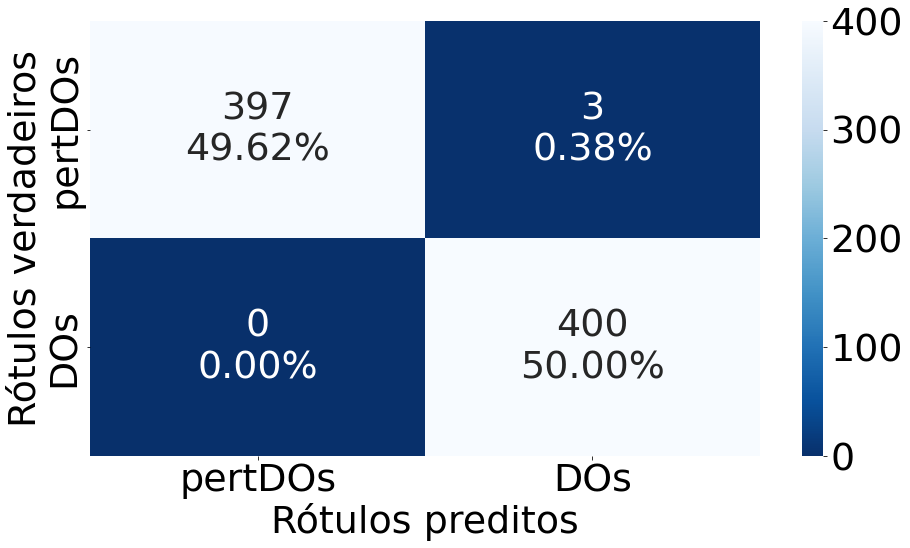

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np

X_alvo =     dfDadosClassificacao['classe'].tolist()
y_predicao = dfDadosClassificacao['predicao'].tolist()

print(classification_report(X_alvo, y_predicao))

# Insere os dados no gráfico
cf_matrix = confusion_matrix(X_alvo, y_predicao)
quantidade_grupos = ["{0:0.0f}".format(valor) for valor in cf_matrix.flatten()]
percentual_grupos = ["{0:.2%}".format(valor) for valor in cf_matrix.flatten()/np.sum(cf_matrix)]
rotulos = [f"{v1}\n{v2}" for v1, v2 in zip(quantidade_grupos,percentual_grupos)]
rotulos = np.asarray(rotulos).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=rotulos, fmt='', cmap='Blues_r')

# Texto do eixo x
ax.set_xlabel('Predicted labels')
# Texto do eixo y
ax.set_ylabel('True labels')
# Rótulos adicionais
ax.xaxis.set_ticklabels(['CDs','ODs'])
ax.yaxis.set_ticklabels(['CDs','ODs'])

# Mostra o gráfico
plt.show()

### Listas em pares

#### Listas de pares de documentos originais e perturbados classificados corretamente

In [ ]:
def listaClassificadoCorretamente(dfDadosClassificacao):
  listaRetorno = []  
  for i, linha in dfDadosClassificacao.iterrows():
    #if i < 20:    
    # 1 - Coerente
    if linha['classe'] == 1 and linha['predicao'] == 1:
        listaRetorno.append(linha['id'])
    # 0 - Incoerente        
    if linha['classe'] == 0 and linha['predicao'] == 0:
        listaRetorno.append(linha['id'])
  
  dflistaRetorno = pd.DataFrame(listaRetorno, columns = ["id"])
  return dflistaRetorno

In [ ]:
listaRetornoClassificadoCorretamente = listaClassificadoCorretamente(dfDadosClassificacao)
print('listaRetornoClassificadoCorretamente:', len(listaRetornoClassificadoCorretamente))

listaRetornoClassificadoCorretamente: 797


#### Listas de pares de documentos originais e perturbados classificados incorretamente

In [ ]:
def listaClassificadoIncorretamente(dfDadosClassificacao):
  listaRetorno = []  
  for i, linha in dfDadosClassificacao.iterrows():
    # 1 - Coerente
    if linha['classe'] == 1 and linha['predicao'] == 0:
        listaRetorno.append(linha['id'])
    # 0 - Incoerente
    if linha['classe'] == 0 and linha['predicao'] == 1:
        listaRetorno.append(linha['id'])
  
  dflistaRetorno = pd.DataFrame(listaRetorno, columns = ["id"])     
  return dflistaRetorno

In [ ]:
listaRetornoClassificadoIncorretamente = listaClassificadoIncorretamente(dfDadosClassificacao)
print('listaRetornoClassificadoIncorretamente:', len(listaRetornoClassificadoIncorretamente))

listaRetornoClassificadoIncorretamente: 3


#### Acurácia das listas

In [ ]:
total = len(listaRetornoClassificadoCorretamente) + len(listaRetornoClassificadoIncorretamente)
print("Total de documentos:", total)
print("Total de acertos   :", len(listaRetornoClassificadoCorretamente))
print("Total de erros     :", len(listaRetornoClassificadoIncorretamente))
print("Acurácia           :", len(listaRetornoClassificadoCorretamente)/total)

Total de documentos: 800
Total de acertos   : 797
Total de erros     : 3
Acurácia           : 0.99625


#### Listas documentos originais e perturbados e suas classificações sem repetições

Remove as duplicidades dos dados originais.

In [ ]:
print("Com repetição:",len(listaRetornoClassificadoCorretamente))
listaRetornoClassificadoCorretamenteSemRepeticao = listaRetornoClassificadoCorretamente.drop_duplicates(subset=['id'])
print("Sem repetição:", len(listaRetornoClassificadoCorretamenteSemRepeticao))

Com repetição: 797
Sem repetição: 417


Remove as duplicidades dos dados perturbados.

In [ ]:
print("Com repetição:",len(listaRetornoClassificadoIncorretamente))
listaRetornoClassificadoIncorretamenteSemRepeticao = listaRetornoClassificadoIncorretamente.drop_duplicates(subset=['id'])
print("Sem repetição:", len(listaRetornoClassificadoIncorretamenteSemRepeticao))

Com repetição: 3
Sem repetição: 3


In [ ]:
print("Documentos originais e perturados e suas classificações:", len(listaRetornoClassificadoCorretamente) + len(listaRetornoClassificadoIncorretamente))
print("  Classificados corretamente(classe=previsão):", len(listaRetornoClassificadoCorretamente))
print("  Classificados incorretamente(classe!=previsão):", len(listaRetornoClassificadoIncorretamente))

DOClasseIncorreta = 0

# Percorre a lista dos documentos originais
for i, linha in lista_documentos_originais.iterrows():
  
  # Limita a quantidade de dados a serem exibidas
  if i < 100:    
  # Procura um documento específico
  #if "Em uma fila a operação de enfileirar ocorre em qual extremidade" in linha['documento']:
    
    # Recupera as POS Tagging do documento original
    documentos_originais_pos = lista_documentos_originais_pos.loc[lista_documentos_originais_pos["id"] == linha['id']]
    #print("documentos_originais_pos[id]:", documentos_originais_pos["id"].values[0])
    
    # Recupera o id documento original se ele foi classificado corretamente    
    documento_id_original = listaRetornoClassificadoCorretamenteSemRepeticao.loc[listaRetornoClassificadoCorretamenteSemRepeticao["id"] == str(linha['id'])]
    #print("documento_id_original:", documento_id_original)

    # Recupera a classificação do original
    classe = ""
    # Se o documento original foi encontrado foi classificado corretamente
    if len(documento_id_original) != 0:
      #print("documento_id_original:",len(documento_id_original))          
      documento = dflista_documentos_agrupados.loc[dflista_documentos_agrupados["id"] == str(documento_id_original['id'].values[0])]
      #print("documento:",documento)
      classe =  str(documento['classe'].values[0])
    else:
      classe = "0"
      DOClasseIncorreta = DOClasseIncorreta + 1

    # Mostra o documento original e sua classificação
    print("\nDO: " + linha["documento"] + " - " + classe)    
    # POSTagging da sentença
    print("    " + " ".join(documentos_originais_pos["pos_documento"].values[0][0][1]))
    
    # Lista com documentos perturbados e sua classificacao
    lista_perturbado_classificado_correto = []
    lista_perturbado_classificado_incorreto = []

    # Percorre os documentos perturbados e suas classificações a partir do original
    for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

        # Id do documento perturbado
        id_perturbado = str(linha['id']) + "_pert_" + str(j)
        #print("id_perturbado:",id_perturbado)

        # localiza os dados do documento perturbado 
        documento_perturbado = lista_documentos_perturbados.loc[lista_documentos_perturbados['id']==id_perturbado].values[0]        
        #print("registro_perturbado_1a_sentenca:", documento_perturbado[3][0][4])
        palavra_mascarada = documento_perturbado[3][0][1]
        token_predito = documento_perturbado[3][0][2]
        peso_predito = documento_perturbado[3][0][3]
        posicao_sorteio = documento_perturbado[3][0][4]

        # Recupera o id documento perturbado se ele foi classificado corretamente
        documento_id_perturbado_correto = listaRetornoClassificadoCorretamenteSemRepeticao.loc[listaRetornoClassificadoCorretamenteSemRepeticao["id"] == id_perturbado]        
        
        # Se foi encontrado foi classificado corretamente
        if len(documento_id_perturbado_correto) != 0:
          versaoPerturbadaClassificada = True
          #print("documento_id_perturbado_correto:",len(documento_id_perturbado_correto))          
          documento = dflista_documentos_agrupados.loc[dflista_documentos_agrupados["id"] == str(documento_id_perturbado_correto['id'].values[0])]
          #print("documento:",documento)
          #saidaPerturbadoCorreto = saidaPerturbadoCorreto + "\n    pert_" + str(j) + ": " + str(documento['documento'].values[0]) + " - " + str(posicao_sorteio) + " - " + str(documento['classe'].values[0])
          lista_perturbado_classificado_correto.append(["pert_" + str(j), str(documento['documento'].values[0]), palavra_mascarada, token_predito, posicao_sorteio, 0 ])

        else:
          # Recupera o id documento perturbado se ele foi classificado incorretamente
          documento_id_perturbado_incorreto = listaRetornoClassificadoIncorretamenteSemRepeticao.loc[listaRetornoClassificadoIncorretamenteSemRepeticao["id"] == id_perturbado]

          # Se foi encontrado foi classificado incorretamente
          if len(documento_id_perturbado_incorreto) != 0:
            #print("documento_id_perturbado_correto:",len(documento_id_perturbado_correto))          
            documento = dflista_documentos_agrupados.loc[dflista_documentos_agrupados["id"] == str(documento_id_perturbado_incorreto['id'].values[0])]
            #print("documento:",documento)
            #saidaPerturbadoIncorreto = saidaPerturbadoIncorreto + "\n    pert_" + str(j) + ": " + str(documento['documento'].values[0]) + " - " + str(posicao_sorteio) + " - 1"            
            lista_perturbado_classificado_incorreto.append(["pert_" + str(j), str(documento['documento'].values[0]), palavra_mascarada, token_predito, posicao_sorteio, 1 ])
                
    lista_perturbado_classificado_correto = sorted(lista_perturbado_classificado_correto, key=lambda x: x[4], reverse=False)
    lista_perturbado_classificado_incorreto = sorted(lista_perturbado_classificado_incorreto, key=lambda x: x[4], reverse=False)

    # Mostra a saída das classificações
    print("  Classificações corretas (classe = predição): " + str(len(lista_perturbado_classificado_correto)))
    if len(lista_perturbado_classificado_correto) != 0:           
      for i, x in enumerate(lista_perturbado_classificado_correto):
          print("  " , x[1]," [" + x[2] + " -> " + x[3] + "(" + str(x[4]) + ")] - ",x[5])
    
    print("  Classificações incorretas(classe != predição): " + str(len(lista_perturbado_classificado_incorreto)))
    if len(lista_perturbado_classificado_incorreto) != 0:           
      for i, x in enumerate(lista_perturbado_classificado_incorreto):
          print("  " ,  x[1]," [" + x[2] + " -> " + x[3] + "(" + str(x[4]) + ")] - ",x[5])

print("\nDocumentos originais classificados incorretamente:", DOClasseIncorreta)

Documentos originais e perturados e suas classificações: 800
  Classificados corretamente(classe=previsão): 797
  Classificados incorretamente(classe!=previsão): 3

DO: Como enfileirar elementos em uma fila? - 1
    SCONJ VERB NOUN ADP DET NOUN PUNCT
  Classificações corretas (classe = predição): 20
   Como adicionar elementos em uma fila ?  [enfileirar -> adicionar(3)] -  0
   Como conseguir elementos em uma fila ?  [enfileirar -> conseguir(7)] -  0
   Como ver elementos em uma fila ?  [enfileirar -> ver(9)] -  0
   Como separar elementos em uma fila ?  [enfileirar -> separar(11)] -  0
   Como reconhecer elementos em uma fila ?  [enfileirar -> reconhecer(14)] -  0
   Como obter elementos em uma fila ?  [enfileirar -> obter(17)] -  0
   Como obter elementos em uma fila ?  [enfileirar -> obter(17)] -  0
   Como introduzir elementos em uma fila ?  [enfileirar -> introduzir(21)] -  0
   Como ter elementos em uma fila ?  [enfileirar -> ter(23)] -  0
   Como desenhar elementos em uma fila ?

#### Listas documentos originais e perturbados classificados corretamente

In [ ]:
print("Documentos originais e perturbados classificados corretamente(classe=previsão):", len(listaRetornoClassificadoCorretamente))
conta = 0
for i, linha in listaRetornoClassificadoCorretamente.iterrows():
  conta = conta + 1
  if i < 2000:    
    documento = dflista_documentos_agrupados.loc[dflista_documentos_agrupados["id"] == linha["id"]]       
    if len(documento)!= 0:    
      print("   ", conta, documento['documento'].values[0], documento['classe'].values[0])

Documentos originais e perturbados classificados corretamente(classe=previsão): 797
    1 Como desempilhar elementos em uma frase ? 0
    2 Como enfileirar elementos em uma fila? 1
    3 Como enfileirar elementos em uma fila? 1
    4 Como enfileirar elementos em uma fila? 1
    5 Como enfileirar elementos em uma fila? 1
    6 Como desenfileirar elementos em uma fila? 1
    7 Como empilhar e enviar elementos em uma pilha ? 0
    8 O que é uma pilha e como substituir seu elemento ? 0
    9 O que é uma pilha e como definir seu elemento ? 0
    10 O que é uma pilha e como fica seu elemento ? 0
    11 Como empilhar elementos em uma estrutura de dados pilha? 1
    12 Como empilhar elementos em uma estrutura de dados pilha? 1
    13 Como empilhar elementos em uma estrutura de dados pilha? 1
    14 O que é uma fila e como criar seu elemento ? 0
    15 O que é uma fila e como entender seu elemento ? 0
    16 O que é uma pilha e como utilizar um elemento nela ? 0
    17 O que é uma pilha e como 

#### Listas documentos originais e perturbados classificados incorretamente

In [ ]:
print("Documentos originais e perturbados classificados incorretamente(classe!=previsão):", len(listaRetornoClassificadoIncorretamente))
conta = 0
for i, linha in listaRetornoClassificadoIncorretamente.iterrows():
  conta = conta + 1
  if i < 2000:    
    documento = dflista_documentos_agrupados.loc[dflista_documentos_agrupados["id"] == linha["id"]]       
    if len(documento)!= 0:    
      print("   ", conta, documento['documento'].values[0], documento['classe'].values[0])

Documentos originais e perturbados classificados incorretamente(classe!=previsão): 3
    1 Como desempilhar elementos em uma estrutura de longa pilha ? 0
    2 Em uma pilha a operação de empilhar termina em qual extremidade ? 0
    3 Em uma fila a operação de enfileirar parou em qual extremidade ? 0


### Listas

#### Lista de documentos originais(1) classificados corretamente(1)

In [ ]:
def listaOriginalClassificadoCorretamente(dfDadosClassificacao):
  listaRetorno = []  
  for i, linha in dfDadosClassificacao.iterrows():
    if linha['classe'] == 1 and linha['predicao'] == 1:
        listaRetorno.append(linha['id'])

  dflistaRetorno = pd.DataFrame(listaRetorno, columns = ["id"])        
  return dflistaRetorno

In [ ]:
lista_documento_original_classificado_corretamente = listaOriginalClassificadoCorretamente(dfDadosClassificacao)
print('lista_documento_original_classificado_corretamente:', len(lista_documento_original_classificado_corretamente))

listaDocumentoOriginalClassificadoCorretamente: 400


In [ ]:
print("Lista de documentos originais classificados corretamente(coerentes)(classe=1 & previsão=1):", len(lista_documento_original_classificado_corretamente))
for i, documento in lista_documento_original_classificado_corretamente.iterrows():
    # Recupera o documento a ser exibido   
    documento = dflista_documentos_agrupados.loc[dflista_documentos_agrupados["id"] == documento["id"]]   
    
    print("  ",i, "-", documento['documento'].values[0], documento['classe'].values[0])

Lista de documentos originais classificados corretamente(coerentes)(classe=1 & previsão=1): 400
   0 - Como enfileirar elementos em uma fila? 1
   1 - Como enfileirar elementos em uma fila? 1
   2 - Como enfileirar elementos em uma fila? 1
   3 - Como enfileirar elementos em uma fila? 1
   4 - Como desenfileirar elementos em uma fila? 1
   5 - Como empilhar elementos em uma estrutura de dados pilha? 1
   6 - Como empilhar elementos em uma estrutura de dados pilha? 1
   7 - Como empilhar elementos em uma estrutura de dados pilha? 1
   8 - O que é uma pilha e como empilhar seu elemento? 1
   9 - O que é uma pilha e como empilhar seu elemento? 1
   10 - O que é uma pilha e como empilhar seu elemento? 1
   11 - Como empilhar e desempilhar elementos em uma pilha? 1
   12 - O que é uma pilha e como empilhar um elemento nela? 1
   13 - Em uma pilha a operação de empilhar ocorre em qual extremidade? 1
   14 - Em uma pilha a operação de empilhar ocorre em qual extremidade? 1
   15 - Em uma pilh

#### Lista de documento originais(1) classificados incorretamente(0)

In [ ]:
def listaOriginalClassificadoIncorretamente(dfDadosClassificacao):
  listaRetorno = []  
  for i, linha in dfDadosClassificacao.iterrows():
    if linha['classe'] == 1 and linha['predicao'] == 0:
        listaRetorno.append(linha['id'])
  dflistaRetorno = pd.DataFrame(listaRetorno, columns = ["id"])
  return dflistaRetorno

In [ ]:
lista_documento_original_classificado_incorretamente = listaOriginalClassificadoIncorretamente(dfDadosClassificacao)

print("Lista de documentos originais classificados incorretamente:",len(lista_documento_original_classificado_incorretamente))

Lista de documentos originais classificados incorretamente: 0


In [ ]:
print("Lista de documentos originais classificados incorretamente(incoerentes)(classe=1 & previsão=0):", len(lista_documento_original_classificado_incorretamente))
for i, documento in lista_documento_original_classificado_incorretamente.iterrows():
    # Recupera o documento a ser exibido   
    documento = dflista_documentos_agrupados.loc[dflista_documentos_agrupados["id"] == documento["id"]]   
    
    print("  ",i, "-", documento['documento'].values[0], documento['classe'].values[0])

Lista de documentos originais classificados incorretamente(incoerentes)(classe=1 & previsão=0): 0


#### Lista Documentos Perturbados(0) Classificados corretamente(0)

In [ ]:
def listaPerturbadoClassificadoCorretamente(dfDadosClassificacao):
  listaRetorno = []  
  for i, linha in dfDadosClassificacao.iterrows():
    if linha['classe'] == 0 and linha['predicao'] == 0:
        listaRetorno.append(linha['id'])
  dflistaRetorno = pd.DataFrame(listaRetorno, columns = ["id"])
  return dflistaRetorno

In [ ]:
lista_documento_perturbado_classificado_corretamente = listaPerturbadoClassificadoCorretamente(dfDadosClassificacao)
print('lista_documento_perturbado_classificado_corretamente:', len(lista_documento_perturbado_classificado_corretamente))

listaDocumentoPerturbadoClassificadoCorretamente: 397


In [ ]:
print("Lista de documentos perturbados classificados corretamente(incoerentes)(classe=0 & previsão=0):", len(lista_documento_perturbado_classificado_corretamente))
for i, documento in lista_documento_perturbado_classificado_corretamente.iterrows():
    # Recupera o documento a ser exibido   
    documento = dflista_documentos_agrupados.loc[dflista_documentos_agrupados["id"] == documento["id"]]   
    
    print("  ",i, "-", documento['documento'].values[0], documento['classe'].values[0])

Lista de documentos perturbados classificados corretamente(incoerentes)(classe=0 & previsão=0): 397
   0 - Como desempilhar elementos em uma frase ? 0
   1 - Como empilhar e enviar elementos em uma pilha ? 0
   2 - O que é uma pilha e como substituir seu elemento ? 0
   3 - O que é uma pilha e como definir seu elemento ? 0
   4 - O que é uma pilha e como fica seu elemento ? 0
   5 - O que é uma fila e como criar seu elemento ? 0
   6 - O que é uma fila e como entender seu elemento ? 0
   7 - O que é uma pilha e como utilizar um elemento nela ? 0
   8 - O que é uma pilha e como esconder um elemento nela ? 0
   9 - O que é uma pilha e como manter um elemento nela ? 0
   10 - Em uma pilha a operação de eletricidade ocorre em qual extremidade ? 0
   11 - Em uma pilha a operação de contato ocorre em qual extremidade ? 0
   12 - O que é uma fila e como destacar um elemento nela ? 0
   13 - Em uma fila a operação de conexão ocorre em qual extremidade ? 0
   14 - Como empilhar e organizar elem

#### Lista Documentos Perturbados(0) Classificados incorretamente(1)

In [ ]:
def listaPerturbadoClassificadoIncorretamente(dfDadosClassificacao):
  listaRetorno = []  
  for i, linha in dfDadosClassificacao.iterrows():
    if linha['classe'] == 0 and linha['predicao'] == 1:
        listaRetorno.append(linha['id'])
  dflistaRetorno = pd.DataFrame(listaRetorno, columns = ["id"])
  return dflistaRetorno

In [ ]:
lista_documento_perturbado_classificado_incorretamente = listaPerturbadoClassificadoIncorretamente(dfDadosClassificacao)
print('lista_documento_perturbado_classificado_incorretamente:', len(lista_documento_perturbado_classificado_incorretamente))

listaDocumentoPerturbadoClassificadoIncorretamente: 3


In [ ]:
print("Lista de documentos perturbados classificados incorretamente(coerente)(classe=0 & previsão=1):", len(lista_documento_perturbado_classificado_incorretamente))
for i, documento in lista_documento_perturbado_classificado_incorretamente.iterrows():
    # Recupera o documento a ser exibido   
    documento = dflista_documentos_agrupados.loc[dflista_documentos_agrupados["id"] == documento["id"]]   
    
    print("  ",i, "-", documento['documento'].values[0], documento['classe'].values[0])

Lista de documentos perturbados classificados incorretamente(coerente)(classe=0 & previsão=1): 3
   0 - Como desempilhar elementos em uma estrutura de longa pilha ? 0
   1 - Em uma pilha a operação de empilhar termina em qual extremidade ? 0
   2 - Em uma fila a operação de enfileirar parou em qual extremidade ? 0


# 3 Resultado do Cálculo das Medidas de (In)coerência

In [ ]:
# Nome base das saidas do projeto
NOME_BASE_SAIDA = "MedidaCoerenciaSquad2_P_v1"

# Definição dos parâmetros a serem avaliados

## 3.1 Carrega os dados das medidas 

### 3.1.1 Função que encontra a melhor mensuração

In [ ]:
# Import das bibliotecas.
import os
import pandas as pd

def getResultadosMensuracao(DIRETORIO_COHEBERT, 
                            DOCUMENTOS_PERTURBADOS, 
                            TOP_K_PREDICAO):
  
  # Quantidade de documentos a serem perturbados a partir do original.    
  DOCUMENTOS_PERTURBADOS = DOCUMENTOS_PERTURBADOS

  # Quantidade de palavras a serem recuperadas mais próximas da máscara. 
  TOP_K_PREDICAO = TOP_K_PREDICAO

  # MCL a serem avaliados
  MODELO_BERT = ['_BERTimbau', '_BERTmultilingual']
  
  TAMANHO_BERT = ['_base','_large']
  
  MODELO = ['_pretreinado', '_ajustado'] 

  ESTRATEGIA_MEDIDA_NUM = [0, 1]  
  ESTRATEGIA_MEDIDA = ['_mean', '_max']
    
  #["TODAS_AS_PALAVRAS", "SEM_STOPWORDS", "SOMENTE_VERBOS_SUBSTANTIVOS"]
  FILTRO_PALAVRAS_NUM = [0, 1, 2, 3, 4]
  FILTRO_PALAVRAS = ['_tap','_ssw', '_ssb', '_sve', '_svs'] 
  
  # Diretório para salvar o arquivo.
  DIRETORIO_AVALIACAO = "/content/drive/My Drive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/validacao_medicao_palavra/Avaliacao/"  


  MELHOR_MODELO_BERT = ""
  MELHOR_TAMANHO_BERT = ""
  MELHOR_MODELO = ""
  MELHOR_DOCUMENTOS_PERTURBADOS = 0
  MELHOR_TOP_K_PREDICAO = 0  
  MELHOR_ESTRATEGIA_MEDIDA = 0
  MELHOR_FILTRO_PALAVRAS = 0  
  MELHOR_MEDIDA_GERAL = 0  
  MELHOR_MEDIDA_GERAL_STR = ""  
  MELHOR_RESULTADO = -1
  MELHOR_TEMPO = 0

  lista_resultados = []

  lista_tempo_total = []  
  
  # Verifica se o diretório dos resultados existe.
  if os.path.exists(DIRETORIO_AVALIACAO):    
    arquivos = os.listdir(DIRETORIO_AVALIACAO) 
    for modelo_bert in MODELO_BERT:
      for tamanho in TAMANHO_BERT:        
        if modelo_bert != '_BERTmultilingual' or tamanho != '_large':  
          for modelo in MODELO:        
            for documentos_perturbados in DOCUMENTOS_PERTURBADOS:
              for top_k_predicao in TOP_K_PREDICAO:                      
                for estrategia in ESTRATEGIA_MEDIDA:  
                  for filtro_palavra in FILTRO_PALAVRAS:  
                    # Acumuladores.
                    soma_acuracia = 0                    
                    conta_reg = 0
                    for i in range(len(arquivos)):                                    
                      if ((("_P_" + str(documentos_perturbados)+"_") in arquivos[i]) 
                          and (("_K_" + str(top_k_predicao)+"_") in arquivos[i])                                 
                          and (modelo_bert in arquivos[i]) 
                          and (tamanho in arquivos[i]) 
                          and (modelo in arquivos[i]) 
                          and (estrategia in arquivos[i]) 
                          and (filtro_palavra in arquivos[i])):
                             
                        NOME_ARQUIVO_AVALIACAO_COMPLETO = DIRETORIO_AVALIACAO + arquivos[i]                              
                        # Verifica se o arquivo existe.
                        if os.path.isfile(NOME_ARQUIVO_AVALIACAO_COMPLETO):
                          # Carrega os dados do arquivo  
                          dados = pd.read_csv(NOME_ARQUIVO_AVALIACAO_COMPLETO, sep=';')
                      
                          # Mostra os dados do teste da medida.
                          for index, linha in dados.iterrows():        
                              # Cálculo das estatísticas
                              ccos = (linha['ccos'])
                              cman = (linha['cman'])
                              ceuc = (linha['ceuc'])
                              
                              MELHOR_MEDIDA = -1
                              MELHOR_MEDIDA_STR = ""
                              if ccos >= cman and ccos >= ceuc:
                                  MELHOR_MEDIDA_STR = 'ccos'
                                  MELHOR_MEDIDA = ccos
                              else:
                                  if ceuc >= ccos and ceuc >= cman:
                                      MELHOR_MEDIDA_STR = 'ceuc'
                                      MELHOR_MEDIDA = ceuc
                                  else:
                                      if cman >= ccos and cman >= ceuc:
                                         MELHOR_MEDIDA_STR = 'cman'
                                         MELHOR_MEDIDA = cman
                              
                              if MELHOR_MEDIDA > MELHOR_RESULTADO:
                                MELHOR_DOCUMENTOS_PERTURBADOS = documentos_perturbados
                                MELHOR_TOP_K_PREDICAO = top_k_predicao
                                MELHOR_ESTRATEGIA_MEDIDA = estrategia
                                MELHOR_FILTRO_PALAVRAS = filtro_palavra
                                MELHOR_RESULTADO = MELHOR_MEDIDA                                
                                MELHOR_TEMPO = linha['tempo']
                                MELHOR_MEDIDA_GERAL = MELHOR_MEDIDA
                                MELHOR_MEDIDA_GERAL_STR = MELHOR_MEDIDA_STR 
                                MELHOR_MODELO_BERT = modelo_bert
                                MELHOR_TAMANHO_BERT = tamanho
                                MELHOR_MODELO = modelo

                              lista_resultados.append([MELHOR_MODELO_BERT,
                                                       MELHOR_TAMANHO_BERT,
                                                       MELHOR_MODELO,
                                                       documentos_perturbados,
                                                       top_k_predicao, 
                                                       estrategia, 
                                                       filtro_palavra, 
                                                       ccos, 
                                                       ceuc, 
                                                       cman,
                                                       MELHOR_MEDIDA_STR,
                                                       MELHOR_MEDIDA,                                                        
                                                       linha['tempo']])
    
    # Retorno do melhor valor
    if MELHOR_MEDIDA_GERAL_STR == "ccos":
      lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[7], reverse=True)  
    else:
      if MELHOR_MEDIDA_GERAL_STR == "ceuc":
        lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[8], reverse=True)
      else:
        lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[9], reverse=True)

    return MELHOR_MODELO_BERT, MELHOR_TAMANHO_BERT, MELHOR_MODELO, MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_ESTRATEGIA_MEDIDA, MELHOR_FILTRO_PALAVRAS, MELHOR_RESULTADO, MELHOR_TEMPO, MELHOR_MEDIDA_GERAL, MELHOR_MEDIDA_GERAL_STR, lista_resultado_ordenado
  else:
      print('Diretório com os resultados não encontrado')

In [ ]:
# Parametros para o Squad2
DOCUMENTOS_PERTURBADOS = [1, 20]
TOP_K_PREDICAO = [1, 10, 100, 1000]

# Recupera os melhores parâmetros
MELHOR_MODELO_BERT, MELHOR_TAMANHO_BERT, MELHOR_MODELO, MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_ESTRATEGIA_MEDIDA, MELHOR_FILTRO_PALAVRAS, MELHOR_RESULTADO, MELHOR_TEMPO, MELHOR_MEDIDA_GERAL, MELHOR_MEDIDA_GERAL_STR, lista_resultados = getResultadosMensuracao(DIRETORIO_COHEBERT, DOCUMENTOS_PERTURBADOS, TOP_K_PREDICAO)

In [ ]:
print("Parâmetros do melhor resultado do mensurador")
print("\n  Modelo BERT           :", MELHOR_MODELO_BERT, 
      "\n  Tamanho BERT          :", MELHOR_TAMANHO_BERT, 
      "\n  Modelo                :", MELHOR_MODELO,     
      "\n  Documentos Perturbados:", MELHOR_DOCUMENTOS_PERTURBADOS, 
      "\n  Top k predição        :", MELHOR_TOP_K_PREDICAO, 
      "\n  Estratégia            :", MELHOR_ESTRATEGIA_MEDIDA, 
      "\n  Filtro                :", MELHOR_FILTRO_PALAVRAS, 
      "\n  Resultado             :", MELHOR_RESULTADO, 
      "\n  Medida                :", MELHOR_MEDIDA_GERAL_STR,       
      "\n  Tempo execução        :", MELHOR_TEMPO)

print("\nLista dos resultados ranqueados")
for i, linha in enumerate(lista_resultados):
    print((i+1),"=", linha)

Parâmetros do melhor resultado do mensurador

  Modelo BERT           : _BERTimbau 
  Tamanho BERT          : _large 
  Modelo                : _pretreinado 
  Documentos Perturbados: 1 
  Top k predição        : 1000 
  Estratégia            : _mean 
  Filtro                : _svs 
  Resultado             : 0.9 
  Medida                : ceuc 
  Tempo execução        : 0:01:12

Lista dos resultados ranqueados
1 = ['_BERTimbau', '_large', '_pretreinado', 1, 1000, '_mean', '_svs', 0.7, 0.9, 0.9, 'ceuc', 0.9, '0:01:12']
2 = ['_BERTimbau', '_large', '_pretreinado', 20, 1000, '_mean', '_ssw', 0.6325, 0.875, 0.87, 'ceuc', 0.875, '0:06:14']
3 = ['_BERTimbau', '_large', '_pretreinado', 20, 1000, '_mean', '_svs', 0.69, 0.865, 0.8625, 'ceuc', 0.865, '0:06:06']
4 = ['_BERTimbau', '_large', '_pretreinado', 1, 1000, '_mean', '_ssw', 0.6, 0.85, 0.8, 'ceuc', 0.85, '0:01:13']
5 = ['_BERTimbau', '_large', '_pretreinado', 1, 10, '_mean', '_ssw', 0.8, 0.8, 0.85, 'cman', 0.85, '0:01:11']
6 = ['_BERTimbau

### Escolhendo um resultado diferente do melhor

In [ ]:
#MELHOR_MODELO_BERT = "_BERTimbau"
#MELHOR_TAMANHO_BERT = "_large"
#MELHOR_MODELO = "_pretreinado"
#MELHOR_DOCUMENTOS_PERTURBADOS = 1
#MELHOR_TOP_K_PREDICAO = 1000
#MELHOR_ESTRATEGIA_MEDIDA = "_max"
#MELHOR_FILTRO_PALAVRAS = "_ssw"
#lista_resultados= []

### 3.1.1 Função que carrega os parâmetros do resultado da melhor mensuração

In [ ]:
def carregaMedidasCompactada(MODELO_BERT, 
                   TAMANHO_BERT, 
                   MODELO, 
                   DOCUMENTOS_PERTURBADOS, 
                   TOP_K_PREDICOES,
                   EQUACAO_MEDIDA, 
                   ESTRATEGIA_MEDIDA, 
                   FILTRO_PALAVRAS):
  # Import das bibliotecas.
  import os
  import pandas as pd

  # Nome arquivo a ser aberto
  NOME_ARQUIVO_MEDICAO = NOME_BASE_SAIDA + "_P_" + str(DOCUMENTOS_PERTURBADOS) + "_K_" + str(TOP_K_PREDICOES) + EQUACAO_MEDIDA + ESTRATEGIA_MEDIDA + FILTRO_PALAVRAS + MODELO_BERT + TAMANHO_BERT + MODELO

  # Diretório do drive do arquivo
  DIRETORIO_MEDICAO_DRIVE = DIRETORIO_DRIVE + "validacao_medicao_palavra/Medicao/"

  # Diretório local para salvar o arquivo
  DIRETORIO_MEDICAO_LOCAL = DIRETORIO_LOCAL + "Medicao/"

  # Verifica se o diretório existe
  if not os.path.exists(DIRETORIO_MEDICAO_LOCAL):  
    # Cria o diretório
    os.makedirs(DIRETORIO_MEDICAO_LOCAL)
    logging.info("Diretório criado: {}.".format(DIRETORIO_MEDICAO_LOCAL))
  else:
    logging.info("Diretório já existe: {}.".format(DIRETORIO_MEDICAO_LOCAL))

  # Verifica se o diretório dos resultados existem.
  if os.path.exists(DIRETORIO_MEDICAO_DRIVE):        

    # Caminho completo do arquivo compactado no drive
    NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO = DIRETORIO_MEDICAO_DRIVE + NOME_ARQUIVO_MEDICAO + ".zip"
    # print("NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO:", NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO)

    # Caminho completo do arquivo compactado no local
    NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO = DIRETORIO_MEDICAO_LOCAL + NOME_ARQUIVO_MEDICAO + ".zip"
    # print("NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO:", NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO)

    # Caminho completo do arquivo no local
    NOME_ARQUIVO_MEDICAO_LOCAL = DIRETORIO_MEDICAO_LOCAL + NOME_ARQUIVO_MEDICAO + ".csv"
    # print("NOME_ARQUIVO_MEDICAO_LOCAL:", NOME_ARQUIVO_MEDICAO_LOCAL)

    # Verifica se o arquivo existe.
    if os.path.isfile(NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO):
      
      # Copia arquivo da medição compactado do google drive para o drive local
      !cp "$NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO" "$NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO"  
                        
      # Descompacta arquivo da medição compactado no drive local
      !unzip -o -j -q "$NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO" -d "$DIRETORIO_MEDICAO_LOCAL"

      # Carrega os dados do arquivo  
      dados_medida = pd.read_csv(NOME_ARQUIVO_MEDICAO_LOCAL, sep=';')

      #print('Registros: ', len(dados_medida))
      print('Arquivo encontrado e carregado')        

      return dados_medida
      
    else:
      print('Arquivo com as medições não encontrado')        

  else:
    print('Diretório com as medições não encontrado')
  
  return None

In [ ]:
def carregaMedidas1(MODELO_BERT, 
                   TAMANHO_BERT, 
                   MODELO, 
                   DOCUMENTOS_PERTURBADOS, 
                   TOP_K_PREDICOES, 
                   ESTRATEGIA_MEDIDA, 
                   FILTRO_PALAVRAS):
  # Import das bibliotecas.
  import os
  import pandas as pd

  # Nome arquivo a ser aberto
  NOME_ARQUIVO_MEDICAO = NOME_BASE_SAIDA + "_P_" + str(DOCUMENTOS_PERTURBADOS) + "_K_" + str(TOP_K_PREDICOES) + ESTRATEGIA_MEDIDA + FILTRO_PALAVRAS + MODELO_BERT + TAMANHO_BERT + MODELO + ".csv"

  # Diretório para salvar o arquivo.
  DIRETORIO_MEDICAO = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/validacao_medicao_palavra/Medicao/"
                     
  # Verifica se o diretório dos resultados existem.
  if os.path.exists(DIRETORIO_MEDICAO):

    # Caminho completo do arquivo
    NOME_ARQUIVO_MEDICAO_COMPLETO = DIRETORIO_MEDICAO + NOME_ARQUIVO_MEDICAO

    # Verifica se o arquivo existe.
    if os.path.isfile(NOME_ARQUIVO_MEDICAO_COMPLETO):
      # Carrega os dados do arquivo  
      dadosMedida = pd.read_csv(NOME_ARQUIVO_MEDICAO_COMPLETO, sep=';')

      print('Registros: ', len(dadosMedida))

      return dadosMedida
      
    else:
      print('Arquivo com as medições não encontrado')        

  else:
    print('Diretório com as medições não encontrado')
  
  return None

## 3.2 Carregamento dos arquivos de dados originais e perturbados

### 3.2.1 Especifica os nomes dos arquivos de dados



In [ ]:
# Nome do arquivo
NOME_ARQUIVO_ORIGINAL = "original.csv"
NOME_ARQUIVO_ORIGINAL_COMPACTADO = "original.zip"
NOME_ARQUIVO_ORIGINAL_POS = "originalpos.csv"
NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO = "originalpos.zip"

NOME_ARQUIVO_PERTURBADO = "perturbado_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".csv"
NOME_ARQUIVO_PERTURBADO_COMPACTADO = "perturbado_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".zip"
NOME_ARQUIVO_PERTURBADO_POS = "perturbadopos_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".csv"
NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO = "perturbadopos_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".zip"

### 3.2.2 Cria o diretório local para receber os dados

In [ ]:
# Import das bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Perturbados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

2022-03-18 12:47:14,474 : INFO : Diretório já existe: /content/COHEBERT


### 3.2.3 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  logging.info("Terminei a cópia!")

2022-03-18 12:47:15,344 : INFO : Terminei a cópia!


Descompacta os arquivos.

Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Terminei a descompactação!")

2022-03-18 12:47:15,894 : INFO : Terminei a descompactação!


### 3.2.4 Carregamento das lista com os dados dos arquivos originais e perturbados

#### Carrega o arquivo dos dados originais e POS

In [ ]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_documentos_originais = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL, sep=";", encoding="UTF-8")
lista_documentos_originais_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

2022-03-18 12:47:15,918 : INFO : TERMINADO ORIGINAIS: 20.
2022-03-18 12:47:15,921 : INFO : TERMINADO ORIGINAIS POS: 20.


In [ ]:
lista_documentos_originais.sample(5)

,id,sentencas,documento
6,7,['Como desempilhar elementos em uma pilha?'],Como desempilhar elementos em uma pilha?
18,19,['Em uma pilha a operação de empilhar ocorre e...,Em uma pilha a operação de empilhar ocorre em ...
4,5,['Como empilhar elementos em uma estrutura de ...,Como empilhar elementos em uma estrutura de da...
5,6,['Como empilhar e desempilhar elementos em uma...,Como empilhar e desempilhar elementos em uma e...
8,9,['O que é uma pilha e como empilhar seu elemen...,O que é uma pilha e como empilhar seu elemento?


In [ ]:
lista_documentos_originais_pos.sample(5)

,id,pos_documento
14,15,"[[['O', 'que', 'é', 'uma', 'pilha', 'e', 'como..."
3,4,"[[['Como', 'empilhar', 'e', 'desempilhar', 'el..."
16,17,"[[['Como', 'são', 'implementadas', 'as', 'oper..."
10,11,"[[['O', 'que', 'é', 'uma', 'fila', 'e', 'como'..."
9,10,"[[['O', 'que', 'é', 'uma', 'fila', 'e', 'como'..."


#### Corrigir os tipos de colunas dos dados originais e POS

Em dados originais:
- coluna 1 - `sentenças` carregadas do arquivo vem como string e não como lista.

Em dados originais pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [ ]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
lista_documentos_originais["sentencas"] = lista_documentos_originais["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

lista_documentos_originais_pos["pos_documento"] = lista_documentos_originais_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO CORREÇÃO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

2022-03-18 12:47:15,983 : INFO : TERMINADO CORREÇÃO ORIGINAIS: 20.
2022-03-18 12:47:15,987 : INFO : TERMINADO CORREÇÃO ORIGINAIS POS: 20.


#### Carrega o arquivo dos dados perturbados e POS

In [ ]:
# Abre o arquivo e retorna o DataFrame
lista_documentos_perturbados = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO, sep=";", encoding="UTF-8")
lista_documentos_perturbados_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO PERTURBADOS: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO PERTURBADOS POS: {}.".format(len(lista_documentos_perturbados_pos)))

2022-03-18 12:47:16,008 : INFO : TERMINADO PERTURBADOS: 20.
2022-03-18 12:47:16,011 : INFO : TERMINADO PERTURBADOS POS: 20.


In [ ]:
lista_documentos_perturbados.sample(5)

,id,perturbado,documentoPerturbado,sentencas
11,12_pert_0,['O que é uma pilha e como desempilhar um cor ...,O que é uma pilha e como desempilhar um cor ne...,[['O que é uma pilha e como desempilhar um [MA...
3,4_pert_0,['Como guarda e desempilhar elementos em uma p...,Como guarda e desempilhar elementos em uma pil...,[['Como [MASK] e desempilhar elementos em uma ...
16,17_pert_0,['Como são explica as operações de empilhar e ...,Como são explica as operações de empilhar e de...,[['Como são [MASK] as operações de empilhar e ...
8,9_pert_0,['O que é uma pilha e como descoberta seu elem...,O que é uma pilha e como descoberta seu elemen...,[['O que é uma pilha e como [MASK] seu element...
6,7_pert_0,['Como desempilhar elementos em uma mistura ?'],Como desempilhar elementos em uma mistura ?,[['Como desempilhar elementos em uma [MASK] ?'...


In [ ]:
lista_documentos_perturbados_pos.sample(5)

,id,pos_documento
9,10_pert_0,"[[['O', 'que', 'é', 'uma', 'fila', 'e', 'como'..."
7,8_pert_0,"[[['Como', 'desempilhar', 'elementos', 'em', '..."
3,4_pert_0,"[[['Como', 'guarda', 'e', 'desempilhar', 'elem..."
5,6_pert_0,"[[['Como', 'recorrer', 'e', 'desempilhar', 'el..."
13,14_pert_0,"[[['O', 'que', 'é', 'uma', 'pilha', 'e', 'como..."


#### Corrigir os tipos de colunas dos dados perturbados e POS

Em dados perturbados:
- coluna 1 - `perturbado` carregadas do arquivo vem como string e não como lista.
- coluna 3 - `sentencas` carregadas do arquivo vem como string e não como lista.

Em dados perturbados pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [ ]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
lista_documentos_perturbados["perturbado"] = lista_documentos_perturbados["perturbado"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)
lista_documentos_perturbados["sentencas"] = lista_documentos_perturbados["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

lista_documentos_perturbados_pos["pos_documento"] = lista_documentos_perturbados_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO PERTURBADO: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO CORREÇÃO PERTURBADO POS: {}.".format(len(lista_documentos_perturbados_pos)))

2022-03-18 12:47:16,073 : INFO : TERMINADO CORREÇÃO PERTURBADO: 20.
2022-03-18 12:47:16,075 : INFO : TERMINADO CORREÇÃO PERTURBADO POS: 20.


### 3.2.5 Agrupar os dados originais e perturbados

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

print("Processando",len(lista_documentos_originais),"documentos originais")

lista_documentos_agrupados = []

# Barra de progresso dos documentos
lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

# Percorre os documentos
for i, linha_documento in lista_documentos_originais_bar: 
  #if i < 2:
    #print("linha_documento:",linha_documento)
    # Recupera o id do documento
    id_documento = linha_documento[0]     
    #print("id_documento:",id_documento)     
 
    # Carrega a lista das sentenças do documento
    lista_sentenca_documento = linha_documento[1]    
    #print("\nlista_sentenca_documento:",lista_sentenca_documento)
    #print("len(lista_sentenca_documento):",len(lista_sentenca_documento)) 

    # Adiciona o original a lista dos dados agrupados, considerando como coerente(1)
    lista_documentos_agrupados.append([id_documento, lista_sentenca_documento, linha_documento[2], 1])
  
    # Percorre os documentos perturbados apartir do original
    for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

      # Id do documento perturbado
      id_perturbado = str(id_documento) + "_pert_" + str(j)

      # localiza o documento perturbado 
      documento_perturbado = lista_documentos_perturbados.loc[lista_documentos_perturbados['id']==id_perturbado].values[0]
      # Recupera a sentença do documento perturbado
      lista_perturbado = documento_perturbado[1]
          
      # Adiciona o perturbado a lista dos dados agrupados considerando como incoerente(0)
      lista_documentos_agrupados.append([id_perturbado, lista_perturbado, documento_perturbado[2], 0])    

logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

Processando 20 documentos originais


Documentos:   0%|          | 0/20 [00:00<?, ? documento/s]

2022-03-18 12:47:16,201 : INFO : TERMINADO AGRUPAMENTO: 40.


Converte em um dataframe

In [ ]:
# Cria o dataframe da lista
dflista_documentos_agrupados = pd.DataFrame(lista_documentos_agrupados, columns = ["id","sentencas","documento","classe"])

In [ ]:
# Corrige os tipos dos dados da lista agrupada
tipos = {"id": str, "sentencas": object, "documento": str, "classe": int}

dflista_documentos_agrupados = dflista_documentos_agrupados.astype(tipos)

In [ ]:
dflista_documentos_agrupados.sample(5)

,id,sentencas,documento,classe
17,9_pert_0,[O que é uma pilha e como descoberta seu eleme...,O que é uma pilha e como descoberta seu elemen...,0
19,10_pert_0,[O que é uma fila e como esquecer seu elemento ?],O que é uma fila e como esquecer seu elemento ?,0
28,15,[O que é uma pilha e como empilhar e desempilh...,O que é uma pilha e como empilhar e desempilha...,1
25,13_pert_0,[O que é uma fila e como cortar um elemento ne...,O que é uma fila e como cortar um elemento nela ?,0
35,18_pert_0,[Como são algumas as operações de enfileirar e...,Como são algumas as operações de enfileirar e ...,0


In [ ]:
# Importa das bibliotecas
import pandas as pd

# Concatena as listas de documentos originais e perturbados
dflista_documentos_agrupados_pos = pd.concat([lista_documentos_originais_pos, lista_documentos_perturbados_pos])

logging.info("TERMINADO AGRUPAMENTO POS: {}.".format(len(dflista_documentos_agrupados_pos)))

2022-03-18 12:47:16,261 : INFO : TERMINADO AGRUPAMENTO POS: 40.


In [ ]:
# Corrige os tipos dos dados da lista agrupada
tipos = {"id": str}

dflista_documentos_agrupados_pos = dflista_documentos_agrupados_pos.astype(tipos)

In [ ]:
dflista_documentos_agrupados_pos.sample(5)

,id,pos_documento
9,10,"[[[O, que, é, uma, fila, e, como, enfileirar, ..."
0,1,"[[[Como, enfileirar, elementos, em, uma, fila,..."
19,20_pert_0,"[[[Em, uma, fila, a, operação, de, enfileirar,..."
8,9,"[[[O, que, é, uma, pilha, e, como, empilhar, s..."
2,3,"[[[Como, empilhar, elementos, em, uma, pilha, ..."


## 3.3 Carregando o resultado da melhor mensuração

In [ ]:
MODELO_BERT = [MELHOR_MODELO_BERT]
TAMANHO_BERT = [MELHOR_TAMANHO_BERT]
MODELO = [MELHOR_MODELO] 
DOCUMENTOS_PERTURBADOS = [MELHOR_DOCUMENTOS_PERTURBADOS]
TOP_K_PREDICAO = [MELHOR_TOP_K_PREDICAO]
ESTRATEGIA_MEDIDA = [MELHOR_ESTRATEGIA_MEDIDA]
FILTRO_PALAVRAS = [MELHOR_FILTRO_PALAVRAS]  

dadosMensuracao = carregaMedidasCompactada(MELHOR_MODELO_BERT, 
                                 MELHOR_TAMANHO_BERT,
                                 MELHOR_MODELO,
                                 MELHOR_DOCUMENTOS_PERTURBADOS, 
                                 MELHOR_TOP_K_PREDICAO,
                                 MELHOR_ESTRATEGIA_MEDIDA,
                                 MELHOR_FILTRO_PALAVRAS)

Registros:  40


In [ ]:
dadosMensuracao.sample(5)

,data,arquivo,ccos,ceuc,cman
27,26/02/2022 23:27,14_pert_0,0.587706,44.640434,1858.363688
29,26/02/2022 23:27,15_pert_0,0.619036,41.396729,1745.138336
24,26/02/2022 23:27,13,0.667143,31.572395,1506.466715
25,26/02/2022 23:27,13_pert_0,0.665660,34.054365,1606.152995
32,26/02/2022 23:27,17,0.692516,30.389193,1435.072164


### Separa os documentos e remove as repetições

In [ ]:
def separaDocumentos(dadosMedida):
  
  # Separa os originais
  df_original_medida = dadosMedida.loc[dadosMedida['arquivo'].str.contains('pert')==False]
  # Remove os duplicados
  df_original_medida = df_original_medida.drop_duplicates(subset=['arquivo'])
  print('Registros: ', len(df_original_medida))

  # Separa os perturbados
  df_perturbado_medida = dadosMedida.loc[dadosMedida['arquivo'].str.contains('pert')==True]
  # Remove os duplicados
  df_perturbado_medida = df_perturbado_medida.drop_duplicates(subset=['arquivo'])
  print('Registros: ', len(df_perturbado_medida))

  return df_original_medida, df_perturbado_medida  

In [ ]:
df_original_medidaBERT, df_perturbado_medidaBERT = separaDocumentos(dadosMensuracao)

Registros:  20
Registros:  20


### Organiza os pares de documentos

In [ ]:
def organizaParesDocumentos(df_original_medida, df_perturbado_medida):

  # Import das bibliotecas.
  import pandas as pd

  lista_pares_documentos_medidas = []
  # Refaz os pares de documentos
  for i, linha1 in df_original_medida.iterrows():

    for j in range(0,MELHOR_DOCUMENTOS_PERTURBADOS):

      nome_arquivo_perturbado = str(linha1['arquivo']) + "_pert_" + str(j)

      docperturbado = df_perturbado_medida.loc[df_perturbado_medida['arquivo'] == nome_arquivo_perturbado]

      lista_pares_documentos_medidas.append(
                                      [linha1['data'], 
                                       linha1['arquivo'],	
                                       linha1['ccos'], 
                                       linha1['ceuc'], 
                                       linha1['cman'],
                                       
                                       docperturbado['data'].values[0], 
                                       docperturbado['arquivo'].values[0],	
                                       docperturbado['ccos'].values[0], 
                                       docperturbado['ceuc'].values[0], 
                                       docperturbado['cman'].values[0] ],)

  print('Registros antes:', len(lista_pares_documentos_medidas))

  df_lista_pares_documentos_medidas = pd.DataFrame(lista_pares_documentos_medidas, columns=('data_DO', 
                                                                                     'id_DO',
                                                                                     'ccos_DO', 
                                                                                     'ceuc_DO', 
                                                                                     'cman_DO', 
                                                                                     'data_pertDO', 
                                                                                     'id_pertDO', 
                                                                                     'ccos_pertDO', 
                                                                                     'ceuc_pertDO', 
                                                                                     'cman_pertDO')) 
  
  print('Registros depois:', len(df_lista_pares_documentos_medidas))

  return df_lista_pares_documentos_medidas

In [ ]:
df_lista_pares_documentos_medidasBERT = organizaParesDocumentos(df_original_medidaBERT, df_perturbado_medidaBERT)

Registros antes: 20
Registros depois: 20


In [ ]:
df_lista_pares_documentos_medidasBERT.sample(5)

,dataDO,idDO,ccosDO,ceucDO,cmanDO,dataPert,idPert,ccosPert,ceucPert,cmanPert
15,26/02/2022 23:27,16,0.622623,33.268794,1599.332967,26/02/2022 23:27,16_pert_0,0.631640,34.790948,1671.735596
5,26/02/2022 23:27,6,0.732022,30.051659,1339.768237,26/02/2022 23:27,6_pert_0,0.681244,35.119228,1539.280127
16,26/02/2022 23:27,17,0.692516,30.389193,1435.072164,26/02/2022 23:27,17_pert_0,0.690083,34.139450,1555.043376
6,26/02/2022 23:27,7,0.696308,31.573687,1474.252502,26/02/2022 23:27,7_pert_0,0.721903,29.124903,1402.253052
19,26/02/2022 23:27,20,0.634703,36.517831,1726.179138,26/02/2022 23:27,20_pert_0,0.665251,37.670843,1731.712097


In [ ]:
lista_documentos_originais.sample(5)

,id,sentencas,documento
12,13,[O que é uma fila e como enfileirar um element...,O que é uma fila e como enfileirar um elemento...
10,11,[O que é uma fila e como desenfileirar um elem...,O que é uma fila e como desenfileirar um eleme...
13,14,[O que é uma pilha e como empilhar um elemento...,O que é uma pilha e como empilhar um elemento ...
5,6,[Como empilhar e desempilhar elementos em uma ...,Como empilhar e desempilhar elementos em uma e...
18,19,[Em uma pilha a operação de empilhar ocorre em...,Em uma pilha a operação de empilhar ocorre em ...


### Listas em pares

#### Listas de pares de documentos originais e perturbados medidos corretamente

In [ ]:
# Lista os documentos medidos corretamente
def listaMedidaCorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] <= linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])        
        lista_retorno.append(linha['id_pertDO'])
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] <= linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])          
          lista_retorno.append(linha['id_pertDO'])

  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return df_lista_retorno  

In [ ]:
lista_retorno_medido_corretamente = listaMedidaCorretamente(df_lista_pares_documentos_medidasBERT,MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_corretamente:', len(lista_retorno_medido_corretamente))

lista_retorno_medido_corretamente: 8


#### Listas de pares de documentos originais e perturbados classificados incorretamente

In [ ]:
# Lista os documentos medidos incorretamente
def listaMedidaIncorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == 'ccos':
      if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])        
        lista_retorno.append(linha['id_pertDO'])
    else:
       # Medida de distância (euc, man)
       if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])          
          lista_retorno.append(linha['id_pertDO'])

  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  return df_lista_retorno  

In [ ]:
lista_retorno_medido_incorretamente = listaMedidaIncorretamente(df_lista_pares_documentos_medidasBERT,MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_incorretamente:', len(lista_retorno_medido_incorretamente))

lista_retorno_medido_incorretamente: 32


#### Acertos das listas

In [ ]:
total = len(lista_retorno_medido_corretamente) + len(lista_retorno_medido_incorretamente)
print("Total de documentos:", total)
print("Total de acertos   :", len(lista_retorno_medido_corretamente))
print("Total de erros     :", len(lista_retorno_medido_incorretamente))
print("Percentual acerto  :", len(lista_retorno_medido_corretamente)/total)

Total de documentos: 40
Total de acertos   : 8
Total de erros     : 32
Percentual acerto  : 0.2


#### Listas documentos originais e perturbados e suas medições sem repetições

Remove as duplicidades dos dados originais.

In [ ]:
print("Com repetição:",len(lista_retorno_medido_corretamente))
lista_retorno_medido_corretamente_sem_repeticao = lista_retorno_medido_corretamente.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_medido_corretamente))

Com repetição: 8
Sem repetição: 8


Remove as duplicidades dos dados perturbados.

In [ ]:
print("Com repetição:",len(lista_retorno_medido_incorretamente))
lista_retorno_medido_incorretamente_sem_repeticao = lista_retorno_medido_incorretamente.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_medido_incorretamente_sem_repeticao))

Com repetição: 32
Sem repetição: 32


#### Listas documentos originais e perturbados medidos corretamente

In [ ]:
print("Documentos originais e perturbados medidos corretamente(CSm(DO) >= CSm(pertDO)):", len(lista_retorno_medido_corretamente))
conta = 0
for i, linha in lista_retorno_medido_corretamente.iterrows():
  conta = conta + 1
  if i < 2000:    
    documento = dflista_documentos_agrupados.loc[dflista_documentos_agrupados["id"] == linha["id"]]       
    if len(documento)!= 0:    
      print("   ", conta, documento['documento'].values[0], documento['classe'].values[0])

Documentos originais e perturbados medidos corretamente(CSm(DO) >= CSm(pertDO)): 8
    1 Como desempilhar elementos em uma pilha? 1
    2 Como desempilhar elementos em uma imagem ? 0
    3 Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha? 1
    4 Como são feitas as operações de empilhar e desempilhar elementos em uma pilha ? 0
    5 Em uma pilha a operação de empilhar ocorre em qual extremidade? 1
    6 Em uma pilha a operação de empilhar ocorre em qual extremidade ? 0
    7 Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
    8 Em uma fila a operação de entrada ocorre em qual extremidade ? 0


#### Listas documentos originais e perturbados medidos incorretamente

In [ ]:
print("Documentos originais e perturbados classificados incorretamente(CSm(DO) < CSm(pertDO)):", len(lista_retorno_medido_incorretamente))
conta = 0
for i, linha in lista_retorno_medido_incorretamente.iterrows():
  conta = conta + 1
  if i < 2000:    
    documento = dflista_documentos_agrupados.loc[dflista_documentos_agrupados["id"] == linha["id"]]       
    if len(documento)!= 0:    
      print("   ", conta, documento['documento'].values[0], documento['classe'].values[0])

Documentos originais e perturbados classificados incorretamente(CSm(DO) < CSm(pertDO)): 32
    1 Como enfileirar elementos em uma fila? 1
    2 Como colocar elementos em uma fila ? 0
    3 Como desenfileirar elementos em uma fila? 1
    4 Como colocar elementos em uma fila ? 0
    5 Como empilhar elementos em uma pilha? 1
    6 Como colocar elementos em uma pilha ? 0
    7 Como empilhar e desempilhar elementos em uma pilha? 1
    8 Como empilhar e organizar elementos em uma pilha ? 0
    9 Como empilhar elementos em uma estrutura de dados pilha? 1
    10 Como identificar elementos em uma estrutura de dados pilha ? 0
    11 Como empilhar e desempilhar elementos em uma estrutura de dados pilha? 1
    12 Como introduzir e desempilhar elementos em uma estrutura de dados pilha ? 0
    13 Como desempilhar elementos em uma estrutura de dados pilha? 1
    14 Como desempilhar elementos em uma estrutura de uma pilha ? 0
    15 O que é uma pilha e como empilhar seu elemento? 1
    16 O que é uma 

### Listas

#### Lista de documentos originais(1) medidos corretamente(1)

In [ ]:
def listaOriginalMedidoCorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] <= linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])                
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] <= linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])
          
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return df_lista_retorno  

In [ ]:
lista_documento_original_medido_corretamente = listaOriginalMedidoCorretamente(df_lista_pares_documentos_medidasBERT, MELHOR_MEDIDA_GERAL_STR)
print('lista_documento_original_medido_corretamente:', len(lista_documento_original_medido_corretamente))

lista_documento_original_medido_corretamente: 4


In [ ]:
print("Lista de documentos originais medidos corretamente(coerentes) (CSm(DO) >= CSm(pertDO)):", len(lista_documento_original_medido_corretamente))
for i, documento in lista_documento_original_medido_corretamente.iterrows():
    # Recupera o documento a ser exibido   
    documento = dflista_documentos_agrupados.loc[dflista_documentos_agrupados["id"] == documento["id"]]   
    
    print("  ",i, "-", documento['documento'].values[0], documento['classe'].values[0])

Lista de documentos originais medidos corretamente(coerentes) (CSm(DO) >= CSm(pertDO)): 4
   0 - Como desempilhar elementos em uma pilha? 1
   1 - Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha? 1
   2 - Em uma pilha a operação de empilhar ocorre em qual extremidade? 1
   3 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1


#### Lista de documento originais(1) medidos incorretamente(0)

In [ ]:
def listaOriginalMedidoIncorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])                
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])
          
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return df_lista_retorno  

In [ ]:
lista_documento_original_medido_incorretamente = listaOriginalMedidoIncorretamente(df_lista_pares_documentos_medidasBERT, MELHOR_MEDIDA_GERAL_STR)

print("Lista de documentos originais medidos incorretamente:",len(lista_documento_original_medido_incorretamente))

Lista de documentos originais medidos incorretamente: 16


In [ ]:
print("Lista de documentos originais medidos incorretamente(incoerentes)(CSm(DO) > CSm(pertDO)):", len(lista_documento_original_medido_incorretamente))
for i, documento in lista_documento_original_medido_incorretamente.iterrows():
    # Recupera o documento a ser exibido   
    documento = dflista_documentos_agrupados.loc[dflista_documentos_agrupados["id"] == documento["id"]]   
    
    print("  ",i, "-", documento['documento'].values[0], documento['classe'].values[0])

Lista de documentos originais medidos incorretamente(incoerentes)(CSm(DO) > CSm(pertDO)): 16
   0 - Como enfileirar elementos em uma fila? 1
   1 - Como desenfileirar elementos em uma fila? 1
   2 - Como empilhar elementos em uma pilha? 1
   3 - Como empilhar e desempilhar elementos em uma pilha? 1
   4 - Como empilhar elementos em uma estrutura de dados pilha? 1
   5 - Como empilhar e desempilhar elementos em uma estrutura de dados pilha? 1
   6 - Como desempilhar elementos em uma estrutura de dados pilha? 1
   7 - O que é uma pilha e como empilhar seu elemento? 1
   8 - O que é uma fila e como enfileirar seu elemento? 1
   9 - O que é uma fila e como desenfileirar um elemento nela? 1
   10 - O que é uma pilha e como desempilhar um elemento nela? 1
   11 - O que é uma fila e como enfileirar um elemento nela? 1
   12 - O que é uma pilha e como empilhar um elemento nela? 1
   13 - O que é uma pilha e como empilhar e desempilhar seus elementos? 1
   14 - O que é uma fila e como enfileira

#### Lista Documentos Perturbados(0) medidos corretamente(0)

In [ ]:
def listaPerturbadoMedidosCorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] <= linha[ medida + '_pertDO']:
         lista_retorno.append(linha['id_pertDO'])
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] <= linha[ medida + '_pertDO']:
           lista_retorno.append(linha['id_pertDO'])
          
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return df_lista_retorno    

In [ ]:
lista_documento_perturbado_medido_corretamente  = listaPerturbadoMedidosCorretamente(df_lista_pares_documentos_medidasBERT, MELHOR_MEDIDA_GERAL_STR)

print("Lista de documentos perturbados medidos corretamente:",len(lista_documento_perturbado_medido_corretamente ))

Lista de documentos perturbados medidos corretamente: 4


In [ ]:
print("Lista de documentos perturbados medidos corretamente(incoerentes)(CSm(DO) >= CSm(pertDO)):", len(lista_documento_perturbado_medido_corretamente ))
for i, documento in lista_documento_perturbado_medido_corretamente .iterrows():
    # Recupera o documento a ser exibido   
    documento = dflista_documentos_agrupados.loc[dflista_documentos_agrupados["id"] == documento["id"]]   
    
    print("  ",i, "-", documento['documento'].values[0], documento['classe'].values[0])

Lista de documentos perturbados medidos corretamente(incoerentes)(CSm(DO) >= CSm(pertDO)): 4
   0 - Como desempilhar elementos em uma imagem ? 0
   1 - Como são feitas as operações de empilhar e desempilhar elementos em uma pilha ? 0
   2 - Em uma pilha a operação de empilhar ocorre em qual extremidade ? 0
   3 - Em uma fila a operação de entrada ocorre em qual extremidade ? 0


#### Lista Documentos Perturbados(0) medidos  incorretamente(1)

In [ ]:
def listaPerturbadoMedidosIncorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
         lista_retorno.append(linha['id_pertDO'])
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
           lista_retorno.append(linha['id_pertDO'])
          
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return df_lista_retorno    

In [ ]:
lista_documento_perturbado_medido_incorretamente = listaPerturbadoMedidosIncorretamente(df_lista_pares_documentos_medidasBERT, MELHOR_MEDIDA_GERAL_STR)

print("Lista de documentos perturbados medidos incorretamente:",len(lista_documento_perturbado_medido_incorretamente))

Lista de documentos perturbados medidos incorretamente: 16


In [ ]:
print("Lista de documentos perturbados medidos incorretamente(coerentes)(CSm(DO) < CSm(pertDO)):", len(lista_documento_perturbado_medido_incorretamente))
for i, documento in lista_documento_perturbado_medido_incorretamente.iterrows():
    # Recupera o documento a ser exibido   
    documento = dflista_documentos_agrupados.loc[dflista_documentos_agrupados["id"] == documento["id"]]   
    
    print("  ",i, "-", documento['documento'].values[0], documento['classe'].values[0])

Lista de documentos perturbados medidos incorretamente(coerentes)(CSm(DO) < CSm(pertDO)): 16
   0 - Como colocar elementos em uma fila ? 0
   1 - Como colocar elementos em uma fila ? 0
   2 - Como colocar elementos em uma pilha ? 0
   3 - Como empilhar e organizar elementos em uma pilha ? 0
   4 - Como identificar elementos em uma estrutura de dados pilha ? 0
   5 - Como introduzir e desempilhar elementos em uma estrutura de dados pilha ? 0
   6 - Como desempilhar elementos em uma estrutura de uma pilha ? 0
   7 - O que é uma pilha e como identificar seu elemento ? 0
   8 - O que é uma fila e como identificar seu elemento ? 0
   9 - O que é uma fila e como desenfileirar um carro nela ? 0
   10 - O que é uma pilha e como colocar um elemento nela ? 0
   11 - O que é uma fila e como colocar um elemento nela ? 0
   12 - O que é uma pilha e como colocar um elemento nela ? 0
   13 - O que é uma pilha e como separar e desempilhar seus elementos ? 0
   14 - O que é uma fila e como organizar e 

## 3.4 Estatísticas das Medidas

# 5 Compara os resultados

Listas das classificações
* lista_documento_original_classificado_corretamente
* lista_documento_original_classificado_incorretamente
* lista_documento_perturbado_classificado_corretamente
* lista_documento_perturbado_classificado_incorretamente


Lista das medições
* lista_documento_original_medido_corretamente 12
* lista_documento_original_medido_incorretamente 8
* lista_documento_perturbado_medido_corretamente 12
* lista_documento_perturbado_medido_incorretamente 8

In [ ]:
total_classificacao = (len(lista_documento_original_classificado_corretamente) + 
                       len(lista_documento_original_classificado_incorretamente) + 
                       len(lista_documento_perturbado_classificado_corretamente) + 
                       len(lista_documento_perturbado_classificado_incorretamente))
print("total_classificacao:", total_classificacao)

print("DO classificados corretamente:", 
      len(lista_documento_original_classificado_corretamente), 
      " / {0:.2%} do total".format(len(lista_documento_original_classificado_corretamente)/total_classificacao))
print("DO classificados incorretamente:", 
      len(lista_documento_original_classificado_incorretamente), 
      " / {0:.2%} do total".format(len(lista_documento_original_classificado_incorretamente)/total_classificacao))
print("pertDO classificados corretamente:", 
      len(lista_documento_perturbado_classificado_corretamente), 
      " / {0:.2%} do total".format(len(lista_documento_perturbado_classificado_corretamente)/total_classificacao))
print("pertDO classificados incorretamente:", 
      len(lista_documento_perturbado_classificado_incorretamente), 
      " / {0:.2%} do total".format(len(lista_documento_perturbado_classificado_incorretamente)/total_classificacao))

total_medicao = (len(lista_documento_original_medido_corretamente) +
                 len(lista_documento_original_medido_incorretamente) + 
                 len(lista_documento_perturbado_medido_corretamente) + 
                 len(lista_documento_perturbado_medido_incorretamente))

print()
print("total_medicao:",total_medicao)

print("DO medidos corretamente:", 
      len(lista_documento_original_medido_corretamente), 
      " / {0:.2%} do total".format(len(lista_documento_original_medido_corretamente)/total_medicao))
print("DO medidos incorretamente:", 
      len(lista_documento_original_medido_incorretamente), 
      " / {0:.2%} do total".format(len(lista_documento_original_medido_incorretamente)/total_medicao))
print("pertDO medidos corretamente:", 
      len(lista_documento_perturbado_medido_corretamente), 
      " / {0:.2%} do total".format(len(lista_documento_perturbado_medido_corretamente)/total_medicao))
print("pertDO medidos incorretamente:", 
      len(lista_documento_perturbado_medido_incorretamente), 
      " / {0:.2%} do total".format(len(lista_documento_perturbado_medido_incorretamente)/total_medicao))

total_classificacao: 800
DO classificados corretamente: 400  / 50.00% do total
DO classificados incorretamente: 0  / 0.00% do total
pertDO classificados corretamente: 397  / 49.62% do total
pertDO classificados incorretamente: 3  / 0.38% do total

total_medicao: 40
DO medidos corretamente: 18  / 45.00% do total
DO medidos incorretamente: 2  / 5.00% do total
pertDO medidos corretamente: 18  / 45.00% do total
pertDO medidos incorretamente: 2  / 5.00% do total


## Documentos originais classificados e medidos corretamente

In [ ]:
lista_intersecao = []
for i, documento1 in lista_documento_original_classificado_corretamente.iterrows():
  procura = documento1["id"]
  documento2 = lista_documento_original_medido_corretamente.loc[lista_documento_original_medido_corretamente["id"] == procura]
  if len(documento2) != 0:        
      lista_intersecao.append(documento1["id"])

In [ ]:
if len(lista_intersecao) != 0:    
  percentual = len(lista_intersecao)/total_classificacao
  print ("Lista de documentos originais que foram classificados e medidos corretamente: ", len(lista_intersecao), " / {0:.2%} do total".format( percentual))
  for i, x in enumerate(lista_intersecao):
    if i < 100:
      print(x)
else:
  print("Não existe documentos originais que foram classificados e medidos corretamente ")

Lista de documentos originais que foram classificados e medidos corretamente:  360  / 45.00% do total
1
1
1
1
2
5
5
5
9
9
9
4
14
19
19
19
19
10
10
12
12
11
11
11
13
3
20
20
20
6
15
15
17
17
17
17
18
5
9
4
4
4
14
14
14
14
19
10
12
12
12
5
12
12
11
11
13
13
20
20
20
6
3
1
1
6
6
15
15
16
16
16
16
18
18
18
5
5
5
5
5
5
9
9
9
4
4
14
14
19
19
10
12
11
13
13
13
20
1
2


## Documentos originais classificados e medidos incorretamente

In [ ]:
lista_intersecao = []
for i, documento1 in lista_documento_original_classificado_incorretamente.iterrows():
  procura = documento1["id"]
  documento2 = lista_documento_original_medido_incorretamente.loc[lista_documento_original_medido_incorretamente["id"] == procura]
  if len(documento2) != 0:        
      lista_intersecao.append(documento1["id"])

In [ ]:
if len(lista_intersecao) != 0:    
  percentual = len(lista_intersecao)/total_classificacao
  print ("Lista de documentos originais que foram classificados e medidos incorretamente: ", len(lista_intersecao), " / {0:.2%} do total".format( percentual))
  for i, x in enumerate(lista_intersecao):
    if i < 100:
      print(x)
else:
  print("Não existe documentos originais que foram classificados e medidos incorretamente ")

Não existe documentos originais que foram classificados e medidos incorretamente 


## Documentos perturbados classificados e medidos corretamente

In [ ]:
lista_intersecao = []
for i, documento1 in lista_documento_perturbado_classificado_corretamente.iterrows():
  procura = documento1["id"]
  documento2 = lista_documento_perturbado_medido_corretamente.loc[lista_documento_perturbado_medido_corretamente["id"] == procura]
  if len(documento2) != 0:        
      lista_intersecao.append(documento1["id"])

In [ ]:
if len(lista_intersecao) != 0:    
  percentual = len(lista_intersecao)/total_classificacao
  print ("Lista de documentos perturbados que foram classificados e medidos corretamente: ", len(lista_intersecao), " / {0:.2%} do total".format( percentual))
  for i, x in enumerate(lista_intersecao):
    if i < 100:
      print(x)
else:
  print("Não existe documentos perturbados que foram classificados e medidos corretamente ")

Lista de documentos perturbados que foram classificados e medidos corretamente:  18  / 2.25% do total
5_pert_0
10_pert_0
19_pert_0
14_pert_0
16_pert_0
1_pert_0
18_pert_0
9_pert_0
6_pert_0
20_pert_0
17_pert_0
3_pert_0
4_pert_0
13_pert_0
11_pert_0
12_pert_0
2_pert_0
15_pert_0


## Documentos perturbados classificados e medidos incorretamente

In [ ]:
lista_intersecao = []
for i, documento1 in lista_documento_perturbado_classificado_incorretamente.iterrows():
  procura = documento1["id"]
  documento2 = lista_documento_perturbado_medido_incorretamente.loc[lista_documento_perturbado_medido_incorretamente["id"] == procura]
  if len(documento2) != 0:        
      lista_intersecao.append(documento1["id"])

In [ ]:
if len(lista_intersecao) != 0:    
  percentual = len(lista_intersecao)/total_classificacao
  print ("Lista de documentos perturbados que foram classificados e medidos incorretamente: ", len(lista_intersecao), " / {0:.2%} do total".format( percentual))
  for i, x in enumerate(lista_intersecao):
    if i < 20:
      print(x)
else:
  print("Não existe documentos perturbados que foram classificados e medidos incorretamente ")

Não existe documentos perturbados que foram classificados e medidos incorretamente 


# 6 Finalização

## 6.3 Tempo final de processamento

Tempo processamento:  1:34:52 (h:mm:ss)

In [ ]:
 # Pega o tempo atual menos o tempo do início do processamento.
final_processamento = time.time()
tempo_total_processamento = formataTempo(final_processamento - inicio_processamento)

print('')
print('  Tempo processamento:  {:} (h:mm:ss)'.format(tempo_total_processamento))


  Tempo processamento:  0:01:41 (h:mm:ss)
